In [1]:
import os
import re
import ast
import json
import torch
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from tqdm import tqdm
from umap import UMAP
from torch.nn import CosineSimilarity
from scipy.stats import pointbiserialr
from datasets import load_dataset, load_from_disk
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel

tqdm.pandas()

# Seaborn settings
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.color_palette("pastel")
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)

# Matplotlib settings
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif",
  "font.serif": "cm",
  "font.size": 16,
})


/Users/kyle/miniconda3/envs/eval-aug/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Abstract & Intro

In [2]:
# sentiment_bert_delta = 56.91 - 52.05
# print(f"Sentiment BERT delta: {sentiment_bert_delta:.2f}")
# toxic_bert_delta = 60.75 - 53.90
# # toxic_bert_delta = 64.36 - 53.90
# print(f"Toxicity BERT delta: {toxic_bert_delta:.2f}")
# news_bert_delta = 89.75 - 88.57
# print(f"News BERT delta: {news_bert_delta:.2f}")

# mean_bert_delta = (sentiment_bert_delta + toxic_bert_delta + news_bert_delta) / 3
# print(f"Mean BERT delta: {mean_bert_delta:.2f}\n")

In [3]:
# sentiment_t5_delta = 59.83 - 57.99
# print(f"Sentiment T5 delta: {sentiment_t5_delta:.2f}")
# toxic_t5_delta = 63.89 - 58.81
# print(f"Toxicity T5 delta: {toxic_t5_delta:.2f}")
# news_t5_delta = 90.53 - 89.01
# print(f"News T5 delta: {news_t5_delta:.2f}")

# mean_t5_delta = (sentiment_t5_delta + toxic_t5_delta + news_t5_delta) / 3
# print(f"Mean T5 delta: {mean_t5_delta:.2f}\n")

In [4]:
# sentiment_falcon_delta = 44.20 - 47.16
# print(f"Sentiment Falcon delta: {sentiment_falcon_delta:.2f}")
# toxic_falcon_delta = 58.41 - 66.68
# print(f"Toxicity Falcon delta: {toxic_falcon_delta:.2f}")
# news_falcon_delta = 28.16 - 25.96
# print(f"News Falcon delta: {news_falcon_delta:.2f}")

# mean_falcon_delta = (sentiment_falcon_delta + toxic_falcon_delta + news_falcon_delta) / 3
# print(f"Mean Falcon delta: {mean_falcon_delta:.2f}\n")

In [5]:
# sentiment_augmentation_rate = 56.51
# print(f"Sentiment augmentation rate: {sentiment_augmentation_rate:.2f}")
# toxic_augmentation_rate = 66.46
# print(f"Toxicity augmentation rate: {toxic_augmentation_rate:.2f}")
# news_augmentation_rate = 3.76
# print(f"News augmentation rate: {news_augmentation_rate:.2f}")
# mean_augmentation_rate = (sentiment_augmentation_rate + toxic_augmentation_rate + news_augmentation_rate) / 3
# reduction = 100 - mean_augmentation_rate
# print(f"Mean augmentation rate: {reduction:.2f}")

In [6]:
# sentiment_translate_bert_delta = 52.60 - 52.05
# print(f"Sentiment BERT delta: {sentiment_translate_bert_delta:.2f}")
# toxic_translate_bert_delta = 61.65 - 53.90
# print(f"Toxicity BERT delta: {toxic_translate_bert_delta:.2f}")
# news_translate_bert_delta = 88.82 - 88.57
# print(f"News BERT delta: {news_translate_bert_delta:.2f}")

# mean_translate_bert_delta = (sentiment_translate_bert_delta + toxic_translate_bert_delta + news_translate_bert_delta) / 3
# print(f"Mean BERT delta: {mean_translate_bert_delta:.2f}\n")

In [7]:
# sentiment_insert_bert_delta = 51.92 - 52.05
# print(f"Sentiment BERT delta: {sentiment_insert_bert_delta:.2f}")
# toxic_insert_bert_delta = 53.10 - 53.90
# print(f"Toxicity BERT delta: {toxic_insert_bert_delta:.2f}")
# news_insert_bert_delta = 88.84 - 88.57
# print(f"News BERT delta: {news_insert_bert_delta:.2f}")

# mean_insert_bert_delta = (sentiment_insert_bert_delta + toxic_insert_bert_delta + news_insert_bert_delta) / 3
# print(f"Mean BERT delta: {mean_insert_bert_delta:.2f}\n")

In [8]:
# sentiment_sub_bert_delta = 51.78 - 52.05
# print(f"Sentiment BERT delta: {sentiment_sub_bert_delta:.2f}")
# toxic_sub_bert_delta = 53.37 - 53.90
# print(f"Toxicity BERT delta: {toxic_sub_bert_delta:.2f}")
# news_sub_bert_delta = 88.86 - 88.57
# print(f"News BERT delta: {news_sub_bert_delta:.2f}")

# mean_sub_bert_delta = (sentiment_sub_bert_delta + toxic_sub_bert_delta + news_sub_bert_delta) / 3
# print(f"Mean BERT delta: {mean_sub_bert_delta:.2f}\n")

In [9]:
# sentiment_id_bert_delta = 90.85 - 90.38
# print(f"Sentiment BERT delta: {sentiment_id_bert_delta:.2f}")
# toxic_id_bert_delta = 91.45 - 88.46
# print(f"Toxicity BERT delta: {toxic_id_bert_delta:.2f}")
# news_id_bert_delta = 93.53 - 94.43
# print(f"News BERT delta: {news_id_bert_delta:.2f}")

# mean_id_bert_delta = (sentiment_id_bert_delta + toxic_id_bert_delta + news_id_bert_delta) / 3
# print(f"Mean BERT delta: {mean_id_bert_delta:.2f}\n")

In [10]:
# set seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [11]:
# display full dataframes
pd.set_option("display.max_columns", None)

In [12]:
# plotting constants
TITLE_FONT_SIZE = 16
WSPACE = 0.3
FIGURE_HEIGHT = 3
LINE_WIDTH = 2
FIG_SIZE = 4
MARKER_SIZE = 8
X_LABEL_ROTATION = 20
TTA_METHOD_ORDER = {
    "Insert": 0,
    "Substitute": 1,
    "Translate": 2,
    "LLM-TTA: Paraphrase": 3,
    "LLM-TTA: ICR": 4,
}

In [13]:

inference_logs = load_from_disk("data/combined_dataset_multiseed")
list(inference_logs.keys())

['seed=3_BOSS_Sentiment_SST5_BERT_Insert',
 'seed=3_BOSS_Sentiment_SST5_BERT_Substitute',
 'seed=3_BOSS_Sentiment_SST5_BERT_Translate',
 'seed=3_BOSS_Sentiment_SST5_BERT_Paraphrase',
 'seed=3_BOSS_Sentiment_SST5_BERT_ICR',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Insert',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Substitute',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Translate',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Paraphrase',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_ICR',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Insert',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Substitute',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Translate',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Paraphrase',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_ICR',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT6000_Insert',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT6000_Substitute',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT6000

In [14]:
"_".join("seed=58_BOSS_Toxicity_Ablate_Data_ImplicitHate_BERT3000_Paraphrase".split("_")[1:])

'BOSS_Toxicity_Ablate_Data_ImplicitHate_BERT3000_Paraphrase'

In [15]:
def parse_task_name(split_name):
    return "Sentiment" if "Sentiment" in split_name else "Toxicity" if "Toxicity" in split_name else "News"

def parse_distribution(split_name):
    return split_name.split("_")[-3]

def parse_model(split_name):
    return split_name.split("_")[-2]

def parse_tta_method(split_name):
    return split_name.split("_")[-1]

def parse_seed(split_name):
    return int(split_name.split("_")[0].split("seed=")[-1])

def format_split_name(split_name):
    return "_".join(split_name.split("_")[1:])


formatted_method_names = {
    "Insert": "Insert",
    "Substitute": "Substitute",
    "Translate": "Translate",
    "Paraphrase": "LLM-TTA: Paraphrase",
    "ICR": "LLM-TTA: ICR",
}
    

In [16]:
multiseed_inference_logs = {}
for split_name in tqdm(inference_logs):
    seed = parse_seed(split_name)
    if seed not in multiseed_inference_logs:
        multiseed_inference_logs[seed] = {}
    
    formatted_split_name = format_split_name(split_name)
    multiseed_inference_logs[seed][formatted_split_name] = inference_logs[split_name]

multiseed_inference_logs

100%|██████████| 1090/1090 [00:00<00:00, 621082.92it/s]


{3: {'BOSS_Sentiment_SST5_BERT_Insert': Dataset({
      features: ['outcome', 'original_text', 'augmentations', 'generations', 'original_predicted_class', 'tta_predicted_class', 'label', 'tta_inference_latency', 'original_prediction_entropy', 'tta_prediction_entropy', 'prediction_entropy_decreased', 'prediction_entropy_decrease', 'tta_mean_class_probs', 'tta_all_class_probs', 'tta_all_class_entropy'],
      num_rows: 1068
  }),
  'BOSS_Sentiment_SST5_BERT_Substitute': Dataset({
      features: ['outcome', 'original_text', 'augmentations', 'generations', 'original_predicted_class', 'tta_predicted_class', 'label', 'tta_inference_latency', 'original_prediction_entropy', 'tta_prediction_entropy', 'prediction_entropy_decreased', 'prediction_entropy_decrease', 'tta_mean_class_probs', 'tta_all_class_probs', 'tta_all_class_entropy'],
      num_rows: 1068
  }),
  'BOSS_Sentiment_SST5_BERT_Translate': Dataset({
      features: ['outcome', 'original_text', 'augmentations', 'generations', 'origina

## No TTA Baselines

In [17]:
no_tta_accuracies = {}
for seed in multiseed_inference_logs:
    no_tta_accuracies[seed] = {}
    for split_name in tqdm(multiseed_inference_logs[seed], desc=f"Seed = {seed}"):
        split_frame = multiseed_inference_logs[seed][split_name].to_pandas()
        split_no_tta_accuracy = classification_report(split_frame["label"], split_frame["original_predicted_class"], output_dict=True, zero_division=0.0)["accuracy"]
        no_tta_accuracies[seed][split_name] = split_no_tta_accuracy

no_tta_accuracies

Seed = 58: 100%|██████████| 268/268 [00:07<00:00, 37.79it/s] 


{3: {'BOSS_Sentiment_SST5_BERT_Insert': 0.6844569288389513,
  'BOSS_Sentiment_SST5_BERT_Substitute': 0.6844569288389513,
  'BOSS_Sentiment_SST5_BERT_Translate': 0.6850467289719626,
  'BOSS_Sentiment_SST5_BERT_Paraphrase': 0.6844569288389513,
  'BOSS_Sentiment_SST5_BERT_ICR': 0.6844569288389513,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Insert': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Substitute': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Translate': 0.6828358208955224,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Paraphrase': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_ICR': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Insert': 0.6779026217228464,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Substitute': 0.6779026217228464,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Translate': 0.6791044776119403,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Paraphrase': 0.6779026217228464,
  'BOSS_Sentiment_Ablate_Dat

## Analyze Main Results

In [18]:
multiseed_split_data = {}
for seed in multiseed_inference_logs:
    main_results_bert_splits = [split for split in multiseed_inference_logs[seed].keys() if "Ablate" not in split]
    datasets = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
    split_data = {}

    for task_name in datasets:
        if task_name not in split_data:
            split_data[task_name] = {}

        for split in tqdm(main_results_bert_splits, desc=f"Processing splits for {task_name} Seed={seed}"):
            if task_name in split:
                distribution = split.split("_")[-3]
                model = split.split("_")[-2]
                tta_method = split.split("_")[-1]
                baseline_accuracy = classification_report(multiseed_inference_logs[seed][split]["label"], multiseed_inference_logs[seed][split]["original_predicted_class"], output_dict=True, zero_division=0.0)["accuracy"]
                tta_accuracy = classification_report(multiseed_inference_logs[seed][split]["label"], multiseed_inference_logs[seed][split]["tta_predicted_class"], output_dict=True, zero_division=0.0)["accuracy"]
                accuracy_delta = tta_accuracy - baseline_accuracy

                if model not in split_data[task_name]:
                    split_data[task_name][model] = {}

                if tta_method not in split_data[task_name][model]:
                    split_data[task_name][model][tta_method] = {}

                split_data[task_name][model][tta_method][distribution] = {
                    "distribution": distribution,
                    "model": model,
                    "tta_method": tta_method,
                    "baseline_accuracy": baseline_accuracy,
                    "tta_accuracy": tta_accuracy,
                    "accuracy_delta": accuracy_delta
                }

        # get the Accuracy Gain for each method excluding ID
        for model_name in split_data[task_name]:
            for tta_method in split_data[task_name][model_name]:
                accuracies = []
                accuracy_deltas = []
                baseline_accuracies = []
                for distribution in split_data[task_name][model_name][tta_method]:
                    if distribution == "ID":
                        continue

                    current_tta_result = split_data[task_name][model_name][tta_method][distribution]
                    accuracies.append(current_tta_result["tta_accuracy"])
                    accuracy_deltas.append(current_tta_result["accuracy_delta"])
                    baseline_accuracies.append(current_tta_result["baseline_accuracy"])

                split_data[task_name][model_name][tta_method]["mean_accuracy"] = np.mean(accuracies)
                split_data[task_name][model_name][tta_method]["mean_accuracy_delta"] = np.mean(accuracy_deltas)
                split_data[task_name][model_name][tta_method]["mean_baseline_accuracy"] = np.mean(baseline_accuracies)

    # print(json.dumps(split_data, indent=4))
    multiseed_split_data[seed] = split_data

print(json.dumps(multiseed_split_data, indent=4))

Processing splits for AgNewsTweets Seed=58: 100%|██████████| 105/105 [00:00<00:00, 469.76it/s]

{
    "3": {
        "BOSS_Sentiment": {
            "BERT": {
                "Insert": {
                    "SST5": {
                        "distribution": "SST5",
                        "model": "BERT",
                        "tta_method": "Insert",
                        "baseline_accuracy": 0.6844569288389513,
                        "tta_accuracy": 0.6619850187265918,
                        "accuracy_delta": -0.022471910112359494
                    },
                    "SemEval": {
                        "distribution": "SemEval",
                        "model": "BERT",
                        "tta_method": "Insert",
                        "baseline_accuracy": 0.4497623896809233,
                        "tta_accuracy": 0.44937445446610413,
                        "accuracy_delta": -0.00038793521481916837
                    },
                    "Dynasent": {
                        "distribution": "Dynasent",
                        "model": "BERT",
               

In [19]:
multiseed_detailed_results = {}
for seed in multiseed_split_data:
    multiseed_detailed_results[seed] = {}
    detailed_results_records = []
    for task_name in multiseed_split_data[seed]:
        for model_name in multiseed_split_data[seed][task_name]:
            for tta_method in multiseed_split_data[seed][task_name][model_name]:
                for dist in [dist for dist in multiseed_split_data[seed][task_name][model_name][tta_method] if not dist.startswith("mean")]:
                    perf_record = multiseed_split_data[seed][task_name][model_name][tta_method][dist]
                    detailed_results_records.append({
                        "task": task_name,
                        "model": model_name,
                        "tta_method": tta_method,
                        "distribution": dist,
                        "mean_accuracy": perf_record["tta_accuracy"] * 100,
                    })
                    detailed_results_records.append({
                        "task": task_name,
                        "model": model_name,
                        "tta_method": "None",
                        "distribution": dist,
                        "mean_accuracy": perf_record["baseline_accuracy"] * 100,
                    })

    print(f"Seed: {seed}")

    detailed_results_frame = pd.DataFrame(detailed_results_records)
    for task_name in multiseed_split_data[seed]:
        task_frame = detailed_results_frame[detailed_results_frame["task"] == task_name]
        display(task_frame.groupby(["task", "model", "distribution", "tta_method", ]).mean().round(2).T)

    full_sweep_results = detailed_results_frame.groupby(["task", "model", "distribution", "tta_method", ]).mean().round(2)
    full_sweep_results.to_csv(f"data/seed={seed}_detailed_results.csv")
    multiseed_detailed_results[seed] = full_sweep_results

print("Across Seeds")
multiseed_detailed_results

Seed: 3


task          BOSS_Sentiment                                                \
model                   BERT                                                 
distribution        Dynasent                                                 
tta_method               ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy          48.56  41.74  42.71      46.48      42.62     43.52   

task                                                                       \
model                                                                       
distribution   SST5                                               SemEval   
tta_method      ICR Insert   None Paraphrase Substitute Translate     ICR   
mean_accuracy  73.6   66.2  68.46       72.1      67.79     68.32   49.02   

task                                                                         \
model                                                         Falcon          
distribution                                                Dynasent          
tta_method    Insert   None Paraphrase Substitute Translate      ICR Insert   
mean_accuracy  44.94  44.97      47.95      44.84     45.26    40.42  41.48   

task                                                                       \
model                                                                       
distribution                                           SST5                 
tta_method      None Paraphrase Substitute Translate    ICR Insert   None   
mean_accuracy  42.87      41.57      41.62     40.83  51.03  54.03  56.74   

task                                                                 \
model                                                                 
distribution                                  SemEval                 
tta_method    Paraphrase Substitute Translate     ICR Insert   None   
mean_accuracy      53.93      52.15     51.68   39.74  40.77  40.69   

task                                                                  \
model                                               T5                 
distribution                                  Dynasent                 
tta_method    Paraphrase Substitute Translate      ICR Insert   None   
mean_accuracy      40.45      38.11     39.54    52.27   45.6  47.75   

task                                                                           \
model                                                                           
distribution                                    SST5                            
tta_method    Paraphrase Substitute Translate    ICR Insert   None Paraphrase   
mean_accuracy       50.3       44.1     46.64  75.75  72.28  76.23      77.06   

task                                                                 \
model                                                                 
distribution                       SemEval                            
tta_method    Substitute Translate     ICR Insert   None Paraphrase   
mean_accuracy      70.51     73.74   51.11  49.67  50.28      50.86   

task                                
model                               
distribution                        
tta_method    Substitute Translate  
mean_accuracy      48.86     49.41

task          BOSS_Toxicity                                                \
model                  BERT                                                 
distribution       AdvCivil                                                 
tta_method              ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy         51.45  26.09  30.43      63.29      27.54     56.97   

task                                                                      \
model                                                                      
distribution  ImplicitHate                                                 
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.64  65.03  64.53      64.96      66.05     64.35   

task                                                                          \
model                                                                 Falcon   
distribution  Toxigen                                               AdvCivil   
tta_method        ICR Insert   None Paraphrase Substitute Translate      ICR   
mean_accuracy   66.14  66.99  66.67      66.14      65.92     66.17     77.9   

task                                                                      \
model                                                                      
distribution                                                ImplicitHate   
tta_method    Insert   None Paraphrase Substitute Translate          ICR   
mean_accuracy  81.64  81.63      79.95      81.64     81.45        44.45   

task                                                                        \
model                                                                        
distribution                                                Toxigen          
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  41.68  43.26      43.53      44.46     43.13   52.44   48.2   

task                                                                         \
model                                                      T5                 
distribution                                         AdvCivil                 
tta_method      None Paraphrase Substitute Translate      ICR Insert   None   
mean_accuracy  52.44      52.97      50.11     52.66     59.9  42.03  46.82   

task                                                                      \
model                                                                      
distribution                                  ImplicitHate                 
tta_method    Paraphrase Substitute Translate          ICR Insert   None   
mean_accuracy      71.62      40.94     59.27        64.93  64.62  63.93   

task                                                                 \
model                                                                 
distribution                                  Toxigen                 
tta_method    Paraphrase Substitute Translate     ICR Insert   None   
mean_accuracy      64.42      65.34     63.69   66.24  65.71  65.72   

task                                           
model                                          
distribution                                   
tta_method    Paraphrase Substitute Translate  
mean_accuracy      66.35      62.85     67.23

task          AgNewsTweets                                                \
model                 BERT                                                 
distribution        Tweets                                                 
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        89.66  88.94  88.57      89.03      88.67     88.45   

task                                                                       \
model         Falcon                                                   T5   
distribution  Tweets                                               Tweets   
tta_method       ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy   27.6  25.11  25.86      27.65      24.77     26.89  90.23   

task                                                         
model                                                        
distribution                                                 
tta_method    Insert   None Paraphrase Substitute Translate  
mean_accuracy   89.7  88.99      89.84      89.09     89.13

Seed: 17


task          BOSS_Sentiment                                                \
model                   BERT                                                 
distribution        Dynasent                                                 
tta_method               ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy           48.8  42.69  42.71      45.86      41.44     43.52   

task                                                                        \
model                                                                        
distribution    SST5                                               SemEval   
tta_method       ICR Insert   None Paraphrase Substitute Translate     ICR   
mean_accuracy  73.03  68.82  68.46      71.54      67.51     68.32   49.23   

task                                                                         \
model                                                         Falcon          
distribution                                                Dynasent          
tta_method    Insert   None Paraphrase Substitute Translate      ICR Insert   
mean_accuracy  44.79  44.97      47.98      44.81     45.26    40.56  41.76   

task                                                                       \
model                                                                       
distribution                                           SST5                 
tta_method      None Paraphrase Substitute Translate    ICR Insert   None   
mean_accuracy  42.87      41.48      41.06     40.83  51.22  54.96  56.74   

task                                                                 \
model                                                                 
distribution                                  SemEval                 
tta_method    Paraphrase Substitute Translate     ICR Insert   None   
mean_accuracy       53.0      51.03     51.68    39.7   41.0  40.69   

task                                                                  \
model                                               T5                 
distribution                                  Dynasent                 
tta_method    Paraphrase Substitute Translate      ICR Insert   None   
mean_accuracy      40.64      37.75     39.54    52.22  46.69  47.75   

task                                                                           \
model                                                                           
distribution                                    SST5                            
tta_method    Paraphrase Substitute Translate    ICR Insert   None Paraphrase   
mean_accuracy      49.75      44.56     46.64  75.19   72.0  76.23      75.94   

task                                                                 \
model                                                                 
distribution                       SemEval                            
tta_method    Substitute Translate     ICR Insert   None Paraphrase   
mean_accuracy      67.98     73.74   51.16  49.65  50.28      50.84   

task                                
model                               
distribution                        
tta_method    Substitute Translate  
mean_accuracy      48.63     49.41

task          BOSS_Toxicity                                                \
model                  BERT                                                 
distribution       AdvCivil                                                 
tta_method              ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy         51.57  27.42  30.43      62.44      25.72     54.91   

task                                                                      \
model                                                                      
distribution  ImplicitHate                                                 
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.74  64.82  64.53       65.1      65.87     64.47   

task                                                                          \
model                                                                 Falcon   
distribution  Toxigen                                               AdvCivil   
tta_method        ICR Insert   None Paraphrase Substitute Translate      ICR   
mean_accuracy   65.92   67.2  66.67      66.03      65.39     66.38    77.78   

task                                                                      \
model                                                                      
distribution                                                ImplicitHate   
tta_method    Insert   None Paraphrase Substitute Translate          ICR   
mean_accuracy  81.64  81.63      80.31      81.64     81.45        44.31   

task                                                                        \
model                                                                        
distribution                                                Toxigen          
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  41.66  43.25      43.62      44.57     43.13   52.12  48.83   

task                                                                         \
model                                                      T5                 
distribution                                         AdvCivil                 
tta_method      None Paraphrase Substitute Translate      ICR Insert   None   
mean_accuracy  52.44      52.76      50.64     52.66    60.63  42.03  46.82   

task                                                                      \
model                                                                      
distribution                                  ImplicitHate                 
tta_method    Paraphrase Substitute Translate          ICR Insert   None   
mean_accuracy      71.98      41.79     59.27        65.14  64.42  63.93   

task                                                                 \
model                                                                 
distribution                                  Toxigen                 
tta_method    Paraphrase Substitute Translate     ICR Insert   None   
mean_accuracy      64.57      65.47     63.69   66.67  66.03  65.72   

task                                           
model                                          
distribution                                   
tta_method    Paraphrase Substitute Translate  
mean_accuracy      66.56      63.59     67.23

task          AgNewsTweets                                                \
model                 BERT                                                 
distribution        Tweets                                                 
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        89.73  88.85  88.57      88.95      88.82     88.45   

task                                                                       \
model         Falcon                                                   T5   
distribution  Tweets                                               Tweets   
tta_method       ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy  27.83  24.94  25.86      27.56      24.85     26.83  90.25   

task                                                         
model                                                        
distribution                                                 
tta_method    Insert   None Paraphrase Substitute Translate  
mean_accuracy  89.78  88.99       89.9      88.98     89.14

Seed: 46


task          BOSS_Sentiment                                                   \
model                   BERT                                                    
distribution        Dynasent                                      SST5          
tta_method               ICR Insert   None Paraphrase Substitute   ICR Insert   
mean_accuracy          48.96  41.74  42.71       46.0      41.83  73.5  68.82   

task                                                                         \
model                                                                         
distribution                               SemEval                            
tta_method      None Paraphrase Substitute     ICR Insert   None Paraphrase   
mean_accuracy  68.45      71.63      66.67   49.21  44.89  44.98      47.94   

task                                                                          \
model                      Falcon                                              
distribution             Dynasent                                       SST5   
tta_method    Substitute      ICR Insert   None Paraphrase Substitute    ICR   
mean_accuracy      44.75    41.09  41.55  42.87      41.11      41.64  50.94   

task                                                                     \
model                                                                     
distribution                                      SemEval                 
tta_method    Insert   None Paraphrase Substitute     ICR Insert   None   
mean_accuracy  55.52  56.74      53.09      51.69   39.73  40.78  40.69   

task                                                                   \
model                                     T5                            
distribution                        Dynasent                            
tta_method    Paraphrase Substitute      ICR Insert   None Paraphrase   
mean_accuracy      40.71       37.6    52.45   46.2  47.75      49.61   

task                                                                         \
model                                                                         
distribution               SST5                                     SemEval   
tta_method    Substitute    ICR Insert   None Paraphrase Substitute     ICR   
mean_accuracy      44.58  76.12  72.94  76.22      76.59      67.88   51.29   

task                                               
model                                              
distribution                                       
tta_method    Insert   None Paraphrase Substitute  
mean_accuracy  49.67  50.28      50.51      48.73

task          BOSS_Toxicity                                                   \
model                  BERT                                                    
distribution       AdvCivil                                     ImplicitHate   
tta_method              ICR Insert   None Paraphrase Substitute          ICR   
mean_accuracy         51.69  28.38  30.43      64.13      27.17        65.75   

task                                                                     \
model                                                                     
distribution                                      Toxigen                 
tta_method    Insert   None Paraphrase Substitute     ICR Insert   None   
mean_accuracy  65.01  64.53      65.03      65.86   64.97  67.52  66.67   

task                                                                   \
model                                 Falcon                            
distribution                        AdvCivil                            
tta_method    Paraphrase Substitute      ICR Insert   None Paraphrase   
mean_accuracy      65.92      64.97    77.17  81.64  81.64      80.43   

task                                                                       \
model                                                                       
distribution             ImplicitHate                                       
tta_method    Substitute          ICR Insert   None Paraphrase Substitute   
mean_accuracy      81.64        44.26  41.72  43.26       43.7      44.29   

task                                                                       \
model                                                           T5          
distribution  Toxigen                                     AdvCivil          
tta_method        ICR Insert   None Paraphrase Substitute      ICR Insert   
mean_accuracy   52.44  48.62  52.44      52.97      50.96    59.54  42.87   

task                                                                   \
model                                                                   
distribution                               ImplicitHate                 
tta_method      None Paraphrase Substitute          ICR Insert   None   
mean_accuracy  46.86      70.17      42.75        64.91  64.65  63.93   

task                                                                  \
model                                                                  
distribution                        Toxigen                            
tta_method    Paraphrase Substitute     ICR Insert   None Paraphrase   
mean_accuracy      64.44      65.62   66.24  66.45  65.71      66.67   

task                      
model                     
distribution              
tta_method    Substitute  
mean_accuracy      64.33

task          AgNewsTweets                                                \
model                 BERT                                                 
distribution        Tweets                                                 
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        89.81  88.77  88.57      88.95      88.85     88.62   

task                                                                       \
model         Falcon                                                   T5   
distribution  Tweets                                               Tweets   
tta_method       ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy  27.83  25.01  25.86      27.26      24.78     26.89  90.53   

task                                                         
model                                                        
distribution                                                 
tta_method    Insert   None Paraphrase Substitute Translate  
mean_accuracy  89.52  88.99      90.07      89.03     89.13

Seed: 58


task          BOSS_Sentiment                                                \
model                   BERT                                                 
distribution        Dynasent                                                 
tta_method               ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy          49.05  42.04  42.71      45.74      42.52     43.82   

task                                                                        \
model                                                                        
distribution    SST5                                               SemEval   
tta_method       ICR Insert   None Paraphrase Substitute Translate     ICR   
mean_accuracy  73.78  68.35  68.46      71.54       67.7     68.41   49.24   

task                                                                         \
model                                                         Falcon          
distribution                                                Dynasent          
tta_method    Insert   None Paraphrase Substitute Translate      ICR Insert   
mean_accuracy  44.95  44.97      48.11      44.81     45.29    40.58  41.88   

task                                                                       \
model                                                                       
distribution                                           SST5                 
tta_method      None Paraphrase Substitute Translate    ICR Insert   None   
mean_accuracy  42.87      41.37      41.55     40.83  50.94  55.24  56.74   

task                                                                 \
model                                                                 
distribution                                  SemEval                 
tta_method    Paraphrase Substitute Translate     ICR Insert   None   
mean_accuracy      53.75      50.75     51.68   39.52  40.89  40.69   

task                                                                  \
model                                               T5                 
distribution                                  Dynasent                 
tta_method    Paraphrase Substitute Translate      ICR Insert   None   
mean_accuracy      40.72      37.76     39.54    52.78  46.62  47.75   

task                                                                           \
model                                                                           
distribution                                    SST5                            
tta_method    Paraphrase Substitute Translate    ICR Insert   None Paraphrase   
mean_accuracy      49.98      45.37     46.64  75.66  72.19  76.23      76.12   

task                                                                 \
model                                                                 
distribution                       SemEval                            
tta_method    Substitute Translate     ICR Insert   None Paraphrase   
mean_accuracy      69.57     73.74   50.97  49.74  50.28      50.53   

task                                
model                               
distribution                        
tta_method    Substitute Translate  
mean_accuracy      49.07     49.41

task          BOSS_Toxicity                                                \
model                  BERT                                                 
distribution       AdvCivil                                                 
tta_method              ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy         52.42  26.93  30.43      62.08      26.33     54.91   

task                                                                      \
model                                                                      
distribution  ImplicitHate                                                 
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.65  64.96  64.53      64.93      66.13     64.47   

task                                                                          \
model                                                                 Falcon   
distribution  Toxigen                                               AdvCivil   
tta_method        ICR Insert   None Paraphrase Substitute Translate      ICR   
mean_accuracy   65.82  66.99  66.67      66.03       65.5     66.38    78.14   

task                                                                      \
model                                                                      
distribution                                                ImplicitHate   
tta_method    Insert   None Paraphrase Substitute Translate          ICR   
mean_accuracy  81.64  81.63      80.07      81.64     81.45        44.23   

task                                                                        \
model                                                                        
distribution                                                Toxigen          
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy   41.5  43.25      43.64      44.48     43.13   52.02  49.15   

task                                                                         \
model                                                      T5                 
distribution                                         AdvCivil                 
tta_method      None Paraphrase Substitute Translate      ICR Insert   None   
mean_accuracy  52.44      52.87      50.42     52.66    59.78  41.67  46.82   

task                                                                      \
model                                                                      
distribution                                  ImplicitHate                 
tta_method    Paraphrase Substitute Translate          ICR Insert   None   
mean_accuracy      69.08      42.63     59.27        64.81  64.64  63.93   

task                                                                 \
model                                                                 
distribution                                  Toxigen                 
tta_method    Paraphrase Substitute Translate     ICR Insert   None   
mean_accuracy      64.35      65.02     63.69    67.2  65.92  65.72   

task                                           
model                                          
distribution                                   
tta_method    Paraphrase Substitute Translate  
mean_accuracy      66.24      63.59     67.23

task          AgNewsTweets                                                \
model                 BERT                                                 
distribution        Tweets                                                 
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy         89.7  88.91  88.57      88.94      88.73     88.62   

task                                                                       \
model         Falcon                                                   T5   
distribution  Tweets                                               Tweets   
tta_method       ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy  27.99  24.85  25.86      27.55      24.73     26.89   90.2   

task                                                         
model                                                        
distribution                                                 
tta_method    Insert   None Paraphrase Substitute Translate  
mean_accuracy  89.77  88.99      90.12       89.2     89.13

Across Seeds


{3:                                              mean_accuracy
 task          model distribution tta_method               
 AgNewsTweets  BERT  Tweets       ICR                 89.66
                                  Insert              88.94
                                  None                88.57
                                  Paraphrase          89.03
                                  Substitute          88.67
 ...                                                    ...
 BOSS_Toxicity T5    Toxigen      Insert              65.71
                                  None                65.72
                                  Paraphrase          66.35
                                  Substitute          62.85
                                  Translate           67.23
 
 [126 rows x 1 columns],
 17:                                              mean_accuracy
 task          model distribution tta_method               
 AgNewsTweets  BERT  Tweets       ICR                 89.73
      

In [20]:
# create dataframe where there is a column for dataset, model, id_accuracy_delta, and mean_accuracy_delta
records = []
num_seeds = len(multiseed_detailed_results.keys())
print(f"Aggregating results across {num_seeds} seeds")

for seed in multiseed_detailed_results:
    for task_name in tqdm(multiseed_split_data[seed]):
        for model_name in multiseed_split_data[seed][task_name]:
            for tta_method in multiseed_split_data[seed][task_name][model_name]:
                current_tta_result = multiseed_split_data[seed][task_name][model_name][tta_method]
                records.append({
                    "dataset": task_name,
                    "model": model_name,
                    "tta_method": tta_method,
                    "ood_mean_accuracy": current_tta_result["mean_accuracy"] * 100,
                })
                records.append({
                    "dataset": task_name,
                    "model": model_name,
                    "tta_method": "None",
                    "ood_mean_accuracy": current_tta_result["mean_baseline_accuracy"] * 100,
                })

main_results_frame = pd.DataFrame(records)
for model in split_data[task_name]:
    display(model)
    display(main_results_frame[main_results_frame["model"] == model].drop(columns="model").groupby(["dataset", "tta_method"]).agg(['mean', 'std']).round(2).T)

aggregated_main_results = main_results_frame.groupby(["dataset", "model", "tta_method"]).agg(['mean', 'std']).round(2).T

Aggregating results across 4 seeds


100%|██████████| 3/3 [00:00<00:00, 30320.27it/s]


'BERT'

dataset                AgNewsTweets                                      \
tta_method                      ICR Insert   None Paraphrase Substitute   
ood_mean_accuracy mean        89.72  88.86  88.57      88.97      88.77   
                  std          0.06   0.08   0.00       0.04       0.08   

dataset                          BOSS_Sentiment                           \
tta_method             Translate            ICR Insert   None Paraphrase   
ood_mean_accuracy mean     88.53          57.17  51.66  52.05      55.24   
                  std       0.10           0.16   0.49   0.01       0.18   

dataset                                     BOSS_Toxicity                \
tta_method             Substitute Translate           ICR Insert   None   
ood_mean_accuracy mean      51.44     52.41         61.06  53.11  53.88   
                  std        0.32      0.08          0.20   0.40   0.00   

dataset                                                 
tta_method             Paraphrase Substitute Translate  
ood_mean_accuracy mean      64.67      52.70     62.11  
                  std        0.30       0.35      0.33

'T5'

dataset                AgNewsTweets                                      \
tta_method                      ICR Insert   None Paraphrase Substitute   
ood_mean_accuracy mean        90.30  89.69  88.99      89.98      89.08   
                  std          0.15   0.12   0.01       0.13       0.10   

dataset                          BOSS_Sentiment                           \
tta_method             Translate            ICR Insert   None Paraphrase   
ood_mean_accuracy mean     89.13          59.75  56.11  58.09      59.01   
                  std       0.01           0.18   0.18   0.01       0.27   

dataset                                     BOSS_Toxicity                \
tta_method             Substitute Translate           ICR Insert   None   
ood_mean_accuracy mean      54.15      56.6         63.83  57.59  58.83   
                  std        0.50       0.0          0.26   0.27   0.02   

dataset                                                 
tta_method             Paraphrase Substitute Translate  
ood_mean_accuracy mean       67.2      56.99      63.4  
                  std         0.5       0.49       0.0

'Falcon'

dataset                AgNewsTweets                                      \
tta_method                      ICR Insert   None Paraphrase Substitute   
ood_mean_accuracy mean        27.82  24.98  25.86      27.50      24.78   
                  std          0.16   0.11   0.01       0.17       0.05   

dataset                          BOSS_Sentiment                           \
tta_method             Translate            ICR Insert   None Paraphrase   
ood_mean_accuracy mean     26.88          43.79  45.82  46.77      45.15   
                  std       0.03           0.11   0.27   0.00       0.17   

dataset                                     BOSS_Toxicity                \
tta_method             Substitute Translate           ICR Insert   None   
ood_mean_accuracy mean      43.56     44.02         58.11  57.33  59.11   
                  std        0.31      0.00          0.13   0.11   0.01   

dataset                                                 
tta_method             Paraphrase Substitute Translate  
ood_mean_accuracy mean      58.90      58.87     59.08  
                  std        0.09       0.10      0.00

### Get Max STD

In [21]:
# aggregated_main_results.groupby(["dataset", "tta_method"]).drop(columns="model").agg(["std"]).groupby("tta_method").mean().round(4).T

In [22]:
# aggregated_main_results.groupby(["dataset", "model", "tta_method"]).agg(["std"]).max().round(2).T

### Build Main OOD Results LaTEX Table

In [23]:
aggregated_main_results["AgNewsTweets"]["BERT"]

tta_method                ICR  Insert   None  Paraphrase  Substitute  \
ood_mean_accuracy mean  89.72   88.86  88.57       88.97       88.77   
                  std    0.06    0.08   0.00        0.04        0.08   

tta_method              Translate  
ood_mean_accuracy mean      88.53  
                  std        0.10

In [24]:

task_order = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
model_order = ["BERT", "T5", "Falcon"]
tta_order = ["None", "Insert", "Substitute", "Translate", "Paraphrase", "ICR"]
citation_map = {
    "None": "None",
    "Insert": "Insert \citep{Lu2022ImprovedTC}",
    "Substitute": "Substitute \citep{Lu2022ImprovedTC}",
    "Translate": "Translate \citep{Sennrich2015ImprovingNM}",
    "Paraphrase": "LLM--TTA: Paraphrase",
    "ICR": "LLM--TTA: ICR",
}

table_latex_lines = []
for tta_method in tta_order:
    row_entries = [citation_map[tta_method]]
    for task in task_order:
        for model in model_order:
            mean_accuracy = aggregated_main_results[task][model][tta_method]["ood_mean_accuracy"]["mean"]
            std_accuracy = aggregated_main_results[task][model][tta_method]["ood_mean_accuracy"]["std"]
            formatted_acc = None
            if tta_method != "None":
                formatted_acc  = f"{mean_accuracy:.2f}\\% {{\\tiny $\pm {std_accuracy:.1f}$}}"
            else:
                formatted_acc = f"{mean_accuracy:.2f}\\%"
            
            best_acc = max([aggregated_main_results[task][model][method_name]["ood_mean_accuracy"]["mean"] for method_name in tta_order])
            is_best_method = mean_accuracy == best_acc
            if is_best_method:
                formatted_acc = "\\textbf{" + formatted_acc + "}"
            
            row_entries.append(formatted_acc)

    row_latex = "    " + " & ".join(row_entries) + " \\\\"
    print(row_latex)

    table_latex_lines.append(row_latex)
    if tta_method in ["None", "Translate"]:
        dash_line = "    " + "\cdashlinelr{1-10}"
        table_latex_lines.append(dash_line)
        print(dash_line)
            

    None & 52.05\% & 58.09\% & \textbf{46.77\%} & 53.88\% & 58.83\% & \textbf{59.11\%} & 88.57\% & 88.99\% & 25.86\% \\
    \cdashlinelr{1-10}
    Insert \citep{Lu2022ImprovedTC} & 51.66\% {\tiny $\pm 0.5$} & 56.11\% {\tiny $\pm 0.2$} & 45.82\% {\tiny $\pm 0.3$} & 53.11\% {\tiny $\pm 0.4$} & 57.59\% {\tiny $\pm 0.3$} & 57.33\% {\tiny $\pm 0.1$} & 88.86\% {\tiny $\pm 0.1$} & 89.69\% {\tiny $\pm 0.1$} & 24.98\% {\tiny $\pm 0.1$} \\
    Substitute \citep{Lu2022ImprovedTC} & 51.44\% {\tiny $\pm 0.3$} & 54.15\% {\tiny $\pm 0.5$} & 43.56\% {\tiny $\pm 0.3$} & 52.70\% {\tiny $\pm 0.3$} & 56.99\% {\tiny $\pm 0.5$} & 58.87\% {\tiny $\pm 0.1$} & 88.77\% {\tiny $\pm 0.1$} & 89.08\% {\tiny $\pm 0.1$} & 24.78\% {\tiny $\pm 0.1$} \\
    Translate \citep{Sennrich2015ImprovingNM} & 52.41\% {\tiny $\pm 0.1$} & 56.60\% {\tiny $\pm 0.0$} & 44.02\% {\tiny $\pm 0.0$} & 62.11\% {\tiny $\pm 0.3$} & 63.40\% {\tiny $\pm 0.0$} & 59.08\% {\tiny $\pm 0.0$} & 88.53\% {\tiny $\pm 0.1$} & 89.13\% {\tiny $\pm 0.0$} &

## Build Detailed Main Results For Each Split and Seed

In [25]:
multiseed_detailed_results[3].T["AgNewsTweets"]

model           BERT                                               Falcon  \
distribution  Tweets                                               Tweets   
tta_method       ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy  89.66  88.94  88.57      89.03      88.67     88.45   27.6   

model                                                           T5         \
distribution                                                Tweets          
tta_method    Insert   None Paraphrase Substitute Translate    ICR Insert   
mean_accuracy  25.11  25.86      27.65      24.77     26.89  90.23   89.7   

model                                                 
distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  88.99      89.84      89.09     89.13

In [26]:
# Seed 3 Results for each split
for task_name in ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]:
    for tta_method in ["None", "Insert", "Substitute", "Translate", "Paraphrase", "ICR"]:
        split_list = None
        dist_list = {
            "BOSS_Sentiment": ["SST5", "SemEval", "Dynasent"],
            "BOSS_Toxicity": ["Toxic", "Severe Toxic", "Obscene", "Threat", "Insult", "Identity Hate"],
            "AgNewsTweets": ["AgNews", "Tweets"],
        }

        for model_name in ["BERT", "T5", "Falcon"]:
                print(f"Seed 3 {task_name} {model_name} {tta_method}")
                display(multiseed_detailed_results[3].T[task_name][model_name])

Seed 3 BOSS_Sentiment BERT None


distribution  Dynasent                                                SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate   ICR   
mean_accuracy    48.56  41.74  42.71      46.48      42.62     43.52  73.6   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy   66.2  68.46       72.1      67.79     68.32   49.02  44.94   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  44.97      47.95      44.84     45.26

Seed 3 BOSS_Sentiment T5 None


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    52.27   45.6  47.75       50.3       44.1     46.64  75.75   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  72.28  76.23      77.06      70.51     73.74   51.11  49.67   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  50.28      50.86      48.86     49.41

Seed 3 BOSS_Sentiment Falcon None


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    40.42  41.48  42.87      41.57      41.62     40.83  51.03   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  54.03  56.74      53.93      52.15     51.68   39.74  40.77   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  40.69      40.45      38.11     39.54

Seed 3 BOSS_Sentiment BERT Insert


distribution  Dynasent                                                SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate   ICR   
mean_accuracy    48.56  41.74  42.71      46.48      42.62     43.52  73.6   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy   66.2  68.46       72.1      67.79     68.32   49.02  44.94   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  44.97      47.95      44.84     45.26

Seed 3 BOSS_Sentiment T5 Insert


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    52.27   45.6  47.75       50.3       44.1     46.64  75.75   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  72.28  76.23      77.06      70.51     73.74   51.11  49.67   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  50.28      50.86      48.86     49.41

Seed 3 BOSS_Sentiment Falcon Insert


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    40.42  41.48  42.87      41.57      41.62     40.83  51.03   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  54.03  56.74      53.93      52.15     51.68   39.74  40.77   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  40.69      40.45      38.11     39.54

Seed 3 BOSS_Sentiment BERT Substitute


distribution  Dynasent                                                SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate   ICR   
mean_accuracy    48.56  41.74  42.71      46.48      42.62     43.52  73.6   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy   66.2  68.46       72.1      67.79     68.32   49.02  44.94   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  44.97      47.95      44.84     45.26

Seed 3 BOSS_Sentiment T5 Substitute


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    52.27   45.6  47.75       50.3       44.1     46.64  75.75   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  72.28  76.23      77.06      70.51     73.74   51.11  49.67   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  50.28      50.86      48.86     49.41

Seed 3 BOSS_Sentiment Falcon Substitute


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    40.42  41.48  42.87      41.57      41.62     40.83  51.03   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  54.03  56.74      53.93      52.15     51.68   39.74  40.77   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  40.69      40.45      38.11     39.54

Seed 3 BOSS_Sentiment BERT Translate


distribution  Dynasent                                                SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate   ICR   
mean_accuracy    48.56  41.74  42.71      46.48      42.62     43.52  73.6   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy   66.2  68.46       72.1      67.79     68.32   49.02  44.94   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  44.97      47.95      44.84     45.26

Seed 3 BOSS_Sentiment T5 Translate


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    52.27   45.6  47.75       50.3       44.1     46.64  75.75   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  72.28  76.23      77.06      70.51     73.74   51.11  49.67   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  50.28      50.86      48.86     49.41

Seed 3 BOSS_Sentiment Falcon Translate


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    40.42  41.48  42.87      41.57      41.62     40.83  51.03   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  54.03  56.74      53.93      52.15     51.68   39.74  40.77   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  40.69      40.45      38.11     39.54

Seed 3 BOSS_Sentiment BERT Paraphrase


distribution  Dynasent                                                SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate   ICR   
mean_accuracy    48.56  41.74  42.71      46.48      42.62     43.52  73.6   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy   66.2  68.46       72.1      67.79     68.32   49.02  44.94   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  44.97      47.95      44.84     45.26

Seed 3 BOSS_Sentiment T5 Paraphrase


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    52.27   45.6  47.75       50.3       44.1     46.64  75.75   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  72.28  76.23      77.06      70.51     73.74   51.11  49.67   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  50.28      50.86      48.86     49.41

Seed 3 BOSS_Sentiment Falcon Paraphrase


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    40.42  41.48  42.87      41.57      41.62     40.83  51.03   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  54.03  56.74      53.93      52.15     51.68   39.74  40.77   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  40.69      40.45      38.11     39.54

Seed 3 BOSS_Sentiment BERT ICR


distribution  Dynasent                                                SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate   ICR   
mean_accuracy    48.56  41.74  42.71      46.48      42.62     43.52  73.6   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy   66.2  68.46       72.1      67.79     68.32   49.02  44.94   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  44.97      47.95      44.84     45.26

Seed 3 BOSS_Sentiment T5 ICR


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    52.27   45.6  47.75       50.3       44.1     46.64  75.75   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  72.28  76.23      77.06      70.51     73.74   51.11  49.67   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  50.28      50.86      48.86     49.41

Seed 3 BOSS_Sentiment Falcon ICR


distribution  Dynasent                                                 SST5  \
tta_method         ICR Insert   None Paraphrase Substitute Translate    ICR   
mean_accuracy    40.42  41.48  42.87      41.57      41.62     40.83  51.03   

distribution                                                SemEval         \
tta_method    Insert   None Paraphrase Substitute Translate     ICR Insert   
mean_accuracy  54.03  56.74      53.93      52.15     51.68   39.74  40.77   

distribution                                          
tta_method      None Paraphrase Substitute Translate  
mean_accuracy  40.69      40.45      38.11     39.54

Seed 3 BOSS_Toxicity BERT None


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy    51.45  26.09  30.43      63.29      27.54     56.97   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.64  65.03  64.53      64.96      66.05     64.35   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.14  66.99  66.67      66.14      65.92     66.17

Seed 3 BOSS_Toxicity T5 None


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     59.9  42.03  46.82      71.62      40.94     59.27   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        64.93  64.62  63.93      64.42      65.34     63.69   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.24  65.71  65.72      66.35      62.85     67.23

Seed 3 BOSS_Toxicity Falcon None


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     77.9  81.64  81.63      79.95      81.64     81.45   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        44.45  41.68  43.26      43.53      44.46     43.13   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   52.44   48.2  52.44      52.97      50.11     52.66

Seed 3 BOSS_Toxicity BERT Insert


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy    51.45  26.09  30.43      63.29      27.54     56.97   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.64  65.03  64.53      64.96      66.05     64.35   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.14  66.99  66.67      66.14      65.92     66.17

Seed 3 BOSS_Toxicity T5 Insert


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     59.9  42.03  46.82      71.62      40.94     59.27   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        64.93  64.62  63.93      64.42      65.34     63.69   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.24  65.71  65.72      66.35      62.85     67.23

Seed 3 BOSS_Toxicity Falcon Insert


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     77.9  81.64  81.63      79.95      81.64     81.45   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        44.45  41.68  43.26      43.53      44.46     43.13   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   52.44   48.2  52.44      52.97      50.11     52.66

Seed 3 BOSS_Toxicity BERT Substitute


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy    51.45  26.09  30.43      63.29      27.54     56.97   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.64  65.03  64.53      64.96      66.05     64.35   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.14  66.99  66.67      66.14      65.92     66.17

Seed 3 BOSS_Toxicity T5 Substitute


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     59.9  42.03  46.82      71.62      40.94     59.27   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        64.93  64.62  63.93      64.42      65.34     63.69   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.24  65.71  65.72      66.35      62.85     67.23

Seed 3 BOSS_Toxicity Falcon Substitute


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     77.9  81.64  81.63      79.95      81.64     81.45   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        44.45  41.68  43.26      43.53      44.46     43.13   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   52.44   48.2  52.44      52.97      50.11     52.66

Seed 3 BOSS_Toxicity BERT Translate


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy    51.45  26.09  30.43      63.29      27.54     56.97   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.64  65.03  64.53      64.96      66.05     64.35   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.14  66.99  66.67      66.14      65.92     66.17

Seed 3 BOSS_Toxicity T5 Translate


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     59.9  42.03  46.82      71.62      40.94     59.27   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        64.93  64.62  63.93      64.42      65.34     63.69   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.24  65.71  65.72      66.35      62.85     67.23

Seed 3 BOSS_Toxicity Falcon Translate


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     77.9  81.64  81.63      79.95      81.64     81.45   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        44.45  41.68  43.26      43.53      44.46     43.13   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   52.44   48.2  52.44      52.97      50.11     52.66

Seed 3 BOSS_Toxicity BERT Paraphrase


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy    51.45  26.09  30.43      63.29      27.54     56.97   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.64  65.03  64.53      64.96      66.05     64.35   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.14  66.99  66.67      66.14      65.92     66.17

Seed 3 BOSS_Toxicity T5 Paraphrase


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     59.9  42.03  46.82      71.62      40.94     59.27   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        64.93  64.62  63.93      64.42      65.34     63.69   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.24  65.71  65.72      66.35      62.85     67.23

Seed 3 BOSS_Toxicity Falcon Paraphrase


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     77.9  81.64  81.63      79.95      81.64     81.45   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        44.45  41.68  43.26      43.53      44.46     43.13   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   52.44   48.2  52.44      52.97      50.11     52.66

Seed 3 BOSS_Toxicity BERT ICR


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy    51.45  26.09  30.43      63.29      27.54     56.97   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        65.64  65.03  64.53      64.96      66.05     64.35   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.14  66.99  66.67      66.14      65.92     66.17

Seed 3 BOSS_Toxicity T5 ICR


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     59.9  42.03  46.82      71.62      40.94     59.27   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        64.93  64.62  63.93      64.42      65.34     63.69   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   66.24  65.71  65.72      66.35      62.85     67.23

Seed 3 BOSS_Toxicity Falcon ICR


distribution  AdvCivil                                                \
tta_method         ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy     77.9  81.64  81.63      79.95      81.64     81.45   

distribution  ImplicitHate                                                \
tta_method             ICR Insert   None Paraphrase Substitute Translate   
mean_accuracy        44.45  41.68  43.26      43.53      44.46     43.13   

distribution  Toxigen                                                
tta_method        ICR Insert   None Paraphrase Substitute Translate  
mean_accuracy   52.44   48.2  52.44      52.97      50.11     52.66

Seed 3 AgNewsTweets BERT None


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  89.66  88.94  88.57      89.03      88.67     88.45

Seed 3 AgNewsTweets T5 None


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  90.23   89.7  88.99      89.84      89.09     89.13

Seed 3 AgNewsTweets Falcon None


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy   27.6  25.11  25.86      27.65      24.77     26.89

Seed 3 AgNewsTweets BERT Insert


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  89.66  88.94  88.57      89.03      88.67     88.45

Seed 3 AgNewsTweets T5 Insert


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  90.23   89.7  88.99      89.84      89.09     89.13

Seed 3 AgNewsTweets Falcon Insert


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy   27.6  25.11  25.86      27.65      24.77     26.89

Seed 3 AgNewsTweets BERT Substitute


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  89.66  88.94  88.57      89.03      88.67     88.45

Seed 3 AgNewsTweets T5 Substitute


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  90.23   89.7  88.99      89.84      89.09     89.13

Seed 3 AgNewsTweets Falcon Substitute


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy   27.6  25.11  25.86      27.65      24.77     26.89

Seed 3 AgNewsTweets BERT Translate


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  89.66  88.94  88.57      89.03      88.67     88.45

Seed 3 AgNewsTweets T5 Translate


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  90.23   89.7  88.99      89.84      89.09     89.13

Seed 3 AgNewsTweets Falcon Translate


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy   27.6  25.11  25.86      27.65      24.77     26.89

Seed 3 AgNewsTweets BERT Paraphrase


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  89.66  88.94  88.57      89.03      88.67     88.45

Seed 3 AgNewsTweets T5 Paraphrase


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  90.23   89.7  88.99      89.84      89.09     89.13

Seed 3 AgNewsTweets Falcon Paraphrase


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy   27.6  25.11  25.86      27.65      24.77     26.89

Seed 3 AgNewsTweets BERT ICR


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  89.66  88.94  88.57      89.03      88.67     88.45

Seed 3 AgNewsTweets T5 ICR


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy  90.23   89.7  88.99      89.84      89.09     89.13

Seed 3 AgNewsTweets Falcon ICR


distribution  Tweets                                              
tta_method       ICR Insert   None Paraphrase Substitute Translate
mean_accuracy   27.6  25.11  25.86      27.65      24.77     26.89

## Dataset Stats

In [27]:
split_label_value_counts = {}

for split_name in multiseed_inference_logs[3]:
    if "BERT" not in split_name:
        continue

    set_name = split_name.split("_BERT")[0]
    if set_name in split_label_value_counts:
        continue

    split_frame = multiseed_inference_logs[3][split_name].to_pandas()
    label_counts = split_frame["label"].value_counts().to_dict()
    label_counts[-1] = len(split_frame)
    label_counts = {k: label_counts[k] for k in sorted(label_counts)}
    split_label_value_counts[set_name] = label_counts

display(pd.DataFrame(split_label_value_counts))

,BOSS_Sentiment_SST5,BOSS_Sentiment_Ablate_Data_SST5,BOSS_Sentiment_SemEval,BOSS_Sentiment_Ablate_Data_SemEval,BOSS_Sentiment_Dynasent,BOSS_Sentiment_Ablate_Data_Dynasent,BOSS_Toxicity_Toxigen,BOSS_Toxicity_Ablate_Data_Toxigen,BOSS_Toxicity_AdvCivil,BOSS_Toxicity_Ablate_Data_AdvCivil,BOSS_Toxicity_ImplicitHate,BOSS_Toxicity_Ablate_Data_ImplicitHate,AgNewsTweets_Tweets,AgNewsTweets_Ablate_Data_Tweets
-1,1068.0,1068.0,20622.0,20622.0,4320.0,4320.0,942.0,942.0,828.0,828.0,21480.0,21480.0,7602,7602
0,280.0,280.0,3229.0,3229.0,1440.0,1440.0,542.0,542.0,152.0,152.0,13291.0,13291.0,1902,1902
1,399.0,399.0,7059.0,7059.0,1440.0,1440.0,400.0,400.0,676.0,676.0,8189.0,8189.0,1900,1900
2,389.0,389.0,10334.0,10334.0,1440.0,1440.0,NaN,NaN,NaN,NaN,NaN,NaN,1900,1900
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900,1900


# Analyze Across Dataset Sizes

In [28]:
data_ablation_results = []
for seed in multiseed_inference_logs:
    for split_name in tqdm(multiseed_inference_logs[seed], desc=f"Seed = {seed}"):
        if "Ablate_Data" not in split_name:
            continue

        task_name = parse_task_name(split_name)
        data_count = int(split_name.split("_")[-2].replace("BERT", ""))
        tta_method = split_name.split("_")[-1]
        shift_name = split_name.split("_")[-3]
        baseline_accuracy = classification_report(multiseed_inference_logs[seed][split_name]["label"], multiseed_inference_logs[seed][split_name]["original_predicted_class"], output_dict=True)["accuracy"]
        tta_accuracy = classification_report(multiseed_inference_logs[seed][split_name]["label"], multiseed_inference_logs[seed][split_name]["tta_predicted_class"], output_dict=True)["accuracy"]
        data_ablation_results.append({
            "task": task_name,
            "shift": shift_name,
            "seed": seed,
            "data_count": data_count,
            "tta_method": formatted_method_names[tta_method],
            "baseline_accuracy": baseline_accuracy,
            "tta_accuracy": tta_accuracy,
            "acc_gain": tta_accuracy - baseline_accuracy
        })

data_ablation_results_frame = pd.DataFrame(data_ablation_results)
data_ablation_results_frame

Seed = 58: 100%|██████████| 268/268 [00:02<00:00, 98.11it/s] 


,task,shift,seed,data_count,tta_method,baseline_accuracy,tta_accuracy,acc_gain
0,Sentiment,SST5,3,1500,Insert,0.682584,0.683521,0.000936
1,Sentiment,SST5,3,1500,Substitute,0.682584,0.670412,-0.012172
2,Sentiment,SST5,3,1500,Translate,0.682836,0.680037,-0.002799
3,Sentiment,SST5,3,1500,LLM-TTA: Paraphrase,0.682584,0.710674,0.028090
4,Sentiment,SST5,3,1500,LLM-TTA: ICR,0.682584,0.718165,0.035581
...,...,...,...,...,...,...,...,...
683,News,Tweets,58,4800,Insert,0.886477,0.890292,0.003815
684,News,Tweets,58,4800,Substitute,0.886477,0.890555,0.004078
685,News,Tweets,58,4800,Translate,0.886447,0.890921,0.004474
686,News,Tweets,58,4800,LLM-TTA: Paraphrase,0.886477,0.890818,0.004341


In [29]:
data_ablation_results_frame[data_ablation_results_frame["task"] == "Toxicity"]

,task,shift,seed,data_count,tta_method,baseline_accuracy,tta_accuracy,acc_gain
75,Toxicity,Toxigen,3,3000,Insert,0.610403,0.611465,0.001062
76,Toxicity,Toxigen,3,3000,Substitute,0.610403,0.614650,0.004246
77,Toxicity,Toxigen,3,3000,Translate,0.611229,0.606992,-0.004237
78,Toxicity,Toxigen,3,3000,LLM-TTA: Paraphrase,0.610403,0.590234,-0.020170
79,Toxicity,Toxigen,3,3000,LLM-TTA: ICR,0.610403,0.599788,-0.010616
...,...,...,...,...,...,...,...,...
658,Toxicity,AdvCivil,58,48000,Insert,0.336957,0.324879,-0.012077
659,Toxicity,AdvCivil,58,48000,Substitute,0.336957,0.310386,-0.026570
660,Toxicity,AdvCivil,58,48000,Translate,0.336165,0.564320,0.228155
661,Toxicity,AdvCivil,58,48000,LLM-TTA: Paraphrase,0.336957,0.609903,0.272947


In [30]:
toxic_frame = data_ablation_results_frame[data_ablation_results_frame["task"] == "Toxicity"][["task", "seed", "data_count", "tta_method", "acc_gain"]]
toxic_frame[toxic_frame["seed"] == 46]

,task,seed,data_count,tta_method,acc_gain
425,Toxicity,46,3000,Insert,0.007431
426,Toxicity,46,3000,Substitute,0.004246
427,Toxicity,46,3000,Translate,-0.004237
428,Toxicity,46,3000,LLM-TTA: Paraphrase,-0.019108
429,Toxicity,46,3000,LLM-TTA: ICR,-0.022293
...,...,...,...,...,...
495,Toxicity,46,48000,Insert,-0.010870
496,Toxicity,46,48000,Substitute,-0.026570
497,Toxicity,46,48000,Translate,0.228155
498,Toxicity,46,48000,LLM-TTA: Paraphrase,0.275362


In [32]:
display(toxic_frame.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain").T["Toxicity"][3][24000])
display(toxic_frame.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain").T["Toxicity"][17][24000])
display(toxic_frame.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain").T["Toxicity"][46][24000])
display(toxic_frame.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain").T["Toxicity"][58][24000])

tta_method,Insert,LLM-TTA: ICR,LLM-TTA: Paraphrase,Substitute,Translate
acc_gain,-0.00274,0.051408,0.082222,-0.000073,0.058732


tta_method,Insert,LLM-TTA: ICR,LLM-TTA: Paraphrase,Substitute,Translate
acc_gain,-0.004453,0.058882,0.078594,-0.000904,0.058732


tta_method,Insert,LLM-TTA: ICR,LLM-TTA: Paraphrase,Substitute,Translate
acc_gain,-0.005399,0.056558,0.081174,0.000186,0.058732


tta_method,Insert,LLM-TTA: ICR,LLM-TTA: Paraphrase,Substitute,Translate
acc_gain,-0.003391,0.052734,0.079753,0.004563,0.058732


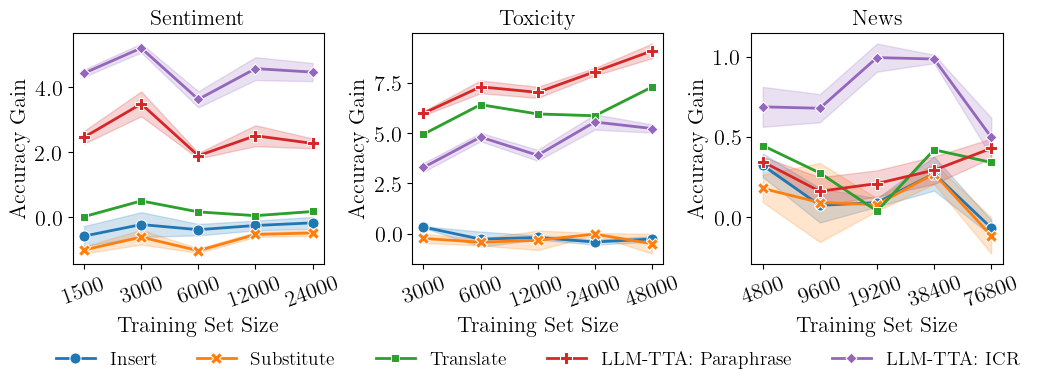

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for i, task_name in enumerate(["Sentiment", "Toxicity", "News"]):
    # df = pd.concat([pd.DataFrame(pandas_form[task_name][data_count]) for data_count in pandas_form[task_name]])
    data_ablation_plotting_df = data_ablation_results_frame[data_ablation_results_frame["task"] == task_name]
    data_ablation_plotting_df = data_ablation_plotting_df[data_ablation_plotting_df["seed"] != 58]
    agg_data_ablation_plotting_df = data_ablation_plotting_df.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain")
    agg_data_ablation_plotting_df = agg_data_ablation_plotting_df.reset_index().sort_values(by=["tta_method"], key=lambda x: x.map(TTA_METHOD_ORDER))
    sns.lineplot(
        data=agg_data_ablation_plotting_df,
        x="data_count",
        y="acc_gain",
        hue="tta_method",
        ax=axes[i],
        linewidth=LINE_WIDTH,
        markersize=MARKER_SIZE,
        style="tta_method",
        dashes=False,
        markers=True,
        errorbar="sd",
    )

    # set x label to Training Set Size
    axes[i].set_xlabel("Training Set Size")

    # set y label to Mean Absolute Accuracy Delta
    axes[i].set_ylabel("Accuracy Gain")

    # make the y axis percents that go to the hundreds place
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize the y axis between the min and max of df
    # axes[i].set_ylim(data_ablation_plotting_df["acc_gain"].min() - 0.005, data_ablation_plotting_df["acc_gain"].max() + 0.005)

    axes[i].set_title(task_name, fontsize=TITLE_FONT_SIZE)

    # se legend to the bottom left
    axes[i].legend(loc="lower right")

    # make x axis log
    axes[i].set_xscale("log")

    # show more x axis ticks at 10%, 20%, 40%, 80%
    x_ticks = sorted(data_ablation_plotting_df["data_count"].unique().tolist())
    tick_labels = [str(int(x)) for x in x_ticks]
    axes[i].set_xticks(x_ticks, tick_labels, minor=False)

    # remove extra ticks not in x_ticks
    axes[i].set_xticks(x_ticks, minor=True)

    # rotate x axis labels
    axes[i].tick_params(axis='x', rotation=X_LABEL_ROTATION)

    # if news add addiitonal precision to the y axis
    # if task_name == "AgNewsTweets":
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.1%}")

    # remove leegnd in not middle plot
    if i != 1:
        axes[i].get_legend().remove()
    else:
        # center below plot with no frame
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=5, frameon=False, fontsize=14)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE)

if not os.path.exists("figures_tmlr/"):
    os.makedirs("figures_tmlr/")

fig.savefig("figures_tmlr/method_analysis_data_ablation.pdf", bbox_inches="tight")
fig.savefig("figures_tmlr/method_analysis_data_ablation.png", bbox_inches="tight")

## Aggregation Ablation Study

In [34]:
def aggregate_predictions(predictions, num_predictions, use_test_input):
    try:
        ablation_preds = predictions[:num_predictions]
        if use_test_input:
            ablation_preds = ablation_preds.tolist() + [predictions[-1]]
        
        mean_distribution = np.mean(ablation_preds, axis=0) if len(ablation_preds) > 1 else ablation_preds[0]
        predicted_class = np.argmax(mean_distribution)
        return predicted_class
    except:
        return -1

perf_records = []
for seed in multiseed_inference_logs:
    agg_ablation_splits = [name for name in multiseed_inference_logs[seed] if "Ablate" not in name and "BERT" in name]
    for split_name in tqdm(agg_ablation_splits, desc=f"Seed = {seed}"):
        dataset = parse_task_name(split_name)
        distribution = parse_distribution(split_name)
        model = parse_model(split_name)
        method = parse_tta_method(split_name)

        current_frame = multiseed_inference_logs[seed][split_name].to_pandas()
        for use_source in [False, True]:
            for num_augmentations in range(1, 5):
                judgments = current_frame["tta_all_class_probs"].apply(lambda x: aggregate_predictions(x, num_augmentations, use_source))
                accuracy = classification_report(current_frame["label"], judgments, output_dict=True, zero_division=0.0)["accuracy"]
                perf_records.append({
                    "dataset": dataset,
                    "seed": seed,
                    "distribution": distribution,
                    "model": model,
                    "method": formatted_method_names[method],
                    "use_source": use_source,
                    "num_augmentations": num_augmentations,
                    "accuracy": accuracy,
                    "delta": accuracy - no_tta_accuracies[seed][split_name],
                })

aggregation_ablation_frame = pd.DataFrame(perf_records)
aggregation_ablation_frame

Seed = 58: 100%|██████████| 35/35 [00:12<00:00,  2.79it/s]


,dataset,seed,distribution,model,method,use_source,num_augmentations,accuracy,delta
0,Sentiment,3,SST5,BERT,Insert,False,1,0.639513,-0.044944
1,Sentiment,3,SST5,BERT,Insert,False,2,0.648876,-0.035581
2,Sentiment,3,SST5,BERT,Insert,False,3,0.654494,-0.029963
3,Sentiment,3,SST5,BERT,Insert,False,4,0.655431,-0.029026
4,Sentiment,3,SST5,BERT,Insert,True,1,0.667603,-0.016854
...,...,...,...,...,...,...,...,...,...
1067,News,58,Tweets,BERT,LLM-TTA: ICR,False,4,0.891607,0.005919
1068,News,58,Tweets,BERT,LLM-TTA: ICR,True,1,0.895685,0.009997
1069,News,58,Tweets,BERT,LLM-TTA: ICR,True,2,0.895948,0.010260
1070,News,58,Tweets,BERT,LLM-TTA: ICR,True,3,0.896080,0.010392


In [35]:
test_frame = aggregation_ablation_frame.copy()[["dataset", "model", "method", "num_augmentations", "use_source", "delta"]]
test_frame = test_frame[test_frame["use_source"] == True]
test_frame.drop(columns="use_source", inplace=True)
test_frame = test_frame.groupby(["dataset", "model", "method", "num_augmentations"]).agg(["mean", "std"]).T * 100
test_frame

dataset                News                                             \
model                  BERT                                              
method               Insert                               LLM-TTA: ICR   
num_augmentations         1         2         3         4            1   
delta mean         0.161142  0.138122  0.256511  0.223625     0.980005   
      std          0.152416  0.050947  0.106597  0.063542     0.086259   

dataset                                                                        \
model                                                                           
method                                          LLM-TTA: Paraphrase             
num_augmentations         2         3         4                   1         2   
delta mean         0.907656  1.009603  0.910944            0.312418 -0.134833   
      std          0.131982  0.068247  0.057213            0.150511  0.044770   

dataset                                                               \
model                                                                  
method                                Substitute                       
num_augmentations         3         4          1         2         3   
delta mean         0.085504 -0.124967  -0.240068 -0.318995  0.006577   
      std          0.068352  0.034803   0.082062  0.069917  0.050947   

dataset                                                             Sentiment  \
model                                                                    BERT   
method                      Translate                                  Insert   
num_augmentations         4         1         2         3         4         1   
delta mean        -0.046041  0.157895 -0.539474 -0.644737 -0.592105 -0.592793   
      std          0.091452  0.000000  0.000000  0.000000  0.000000  0.448743   

dataset                                                                 \
model                                                                    
method                                          LLM-TTA: ICR             
num_augmentations         2         3         4            1         2   
delta mean        -0.705880 -0.785220 -0.775079     3.637945  4.632597   
      std          0.245497  0.549423  0.624630     0.628439  1.009879   

dataset                                                                        \
model                                                                           
method                                LLM-TTA: Paraphrase                       
num_augmentations         3         4                   1         2         3   
delta mean         4.895472  5.068066            2.252989  2.946381  3.279499   
      std          1.036433  1.166040            0.318157  0.445707  0.309075   

dataset                                                               \
model                                                                  
method                      Substitute                                 
num_augmentations         4          1         2         3         4   
delta mean         3.495640  -1.439468 -1.519886 -1.772421 -1.481775   
      std          0.326383   1.054161  1.092306  1.307440  1.000153   

dataset                                                    Toxicity            \
model                                                          BERT             
method            Translate                                  Insert             
num_augmentations         1         2         3         4         1         2   
delta mean         0.067705  0.491015  0.132305  0.082178 -0.309692 -0.563336   
      std          0.791911  0.536428  0.764794  0.606843  0.868671  1.438105   

dataset                                                                   \
model                                                                      
method                                LLM-TTA: ICR                         
num_augmentations         3         4            1          2       

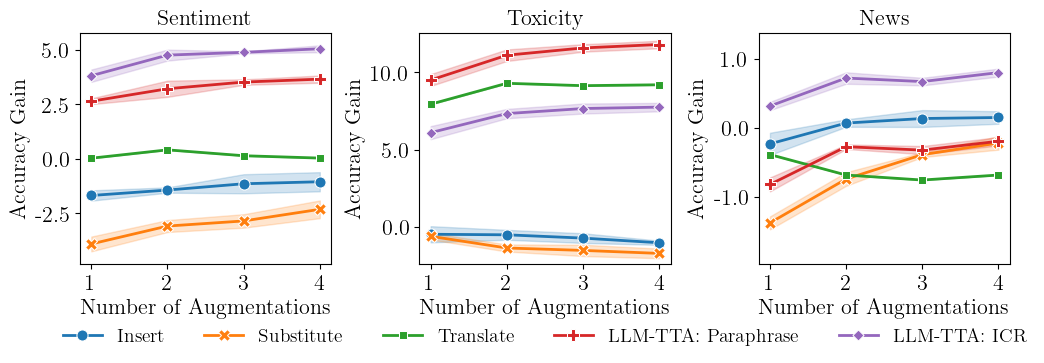

In [36]:
# select where distribution != ID
aggregation_ablation_frame = aggregation_ablation_frame[aggregation_ablation_frame["distribution"] != "ID"]
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for index, task_name in enumerate(["Sentiment", "Toxicity", "News"]):
    # get the current task frame
    current_frame = aggregation_ablation_frame[aggregation_ablation_frame["dataset"] == task_name]
    current_frame = current_frame[current_frame["use_source"] == True]
    current_frame = current_frame.drop(columns="use_source")
    current_frame = current_frame.sort_values(by=["method"], key=lambda x: x.map(TTA_METHOD_ORDER))
    current_frame = aggregation_ablation_frame[aggregation_ablation_frame["dataset"] == task_name]
    current_frame = current_frame.groupby(["dataset", "seed", "num_augmentations", "method"]).mean("delta")
    current_frame = current_frame.reset_index().sort_values(by=["method"], key=lambda x: x.map(TTA_METHOD_ORDER))
    
    sns.lineplot(
        data=current_frame,
        x="num_augmentations",
        y="delta",
        hue="method",
        style="method",
        ax=axes[index],
        linewidth=LINE_WIDTH,
        dashes=False,
        markers=True,
        markersize=MARKER_SIZE,
        errorbar="sd",
    )

    # set x label to Number of Augmentations
    axes[index].set_xlabel("Number of Augmentations")

    # set y label to Accuracy
    axes[index].set_ylabel("Accuracy Gain")

    # make the y axis percents that go to the hundreds place
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # y range is -1 and +1 the min and max of the data
    axes[index].set_ylim(current_frame["delta"].min() - 0.005, current_frame["delta"].max() + 0.005)

    # set x ticks as 1, 2, 3, 4
    axes[index].set_xticks(range(1, 5))

    # set title to Sentiment, Toxicity, or News
    axes[index].set_title(task_name, fontsize=TITLE_FONT_SIZE)

    # se legend to the bottom left
    axes[index].legend(loc="lower right")

    # remove leegnd in not middle plot
    if index != 1:
        axes[index].get_legend().remove()
    else:
        # center below plot with no frame
        axes[index].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=5, frameon=False, fontsize=14)
    
    # have y ticks to the tenths place
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.1%}")

# add padding for labels
fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE)

fig.savefig("figures_tmlr/method_analysis_aggrgeation_ablation.pdf", bbox_inches="tight")
fig.savefig("figures_tmlr/method_analysis_aggrgeation_ablation.png", bbox_inches="tight")

## Does TTA Affect Some Classes More Than Others?

In [37]:
ood_sentiment_icr_data = None
ood_toxicity_icr_data = None
ood_tweets_icr_data = None

for seed in multiseed_inference_logs:
    for split_name in tqdm(multiseed_inference_logs[seed], desc=f"Seed = {3}"):
        if "ICR" not in split_name and "ID" in split_name or "BERT" not in split_name or "Ablate" in split_name:
            continue

        current_frame = multiseed_inference_logs[seed][split_name].to_pandas()
        current_frame["seed"] = seed
        current_frame["dataset"] = parse_distribution(split_name)
        current_frame["outcome"] = current_frame["outcome"].apply(lambda o: "Unfixed Mistake" if o == "NA" else o)

        if "Sentiment" in split_name:
            if ood_sentiment_icr_data is None:
                ood_sentiment_icr_data = current_frame
            else:
                ood_sentiment_icr_data = pd.concat([ood_sentiment_icr_data, current_frame])

        if "Toxicity" in split_name:
            if ood_toxicity_icr_data is None:
                ood_toxicity_icr_data = current_frame
            else:
                ood_toxicity_icr_data = pd.concat([ood_toxicity_icr_data, current_frame])

        if "Tweets" in split_name:
            if ood_tweets_icr_data is None:
                ood_tweets_icr_data = current_frame
            else:
                ood_tweets_icr_data = pd.concat([ood_tweets_icr_data, current_frame])


display(ood_sentiment_icr_data.value_counts("dataset"))
display(ood_toxicity_icr_data.value_counts("dataset"))
display(ood_tweets_icr_data.value_counts("dataset"))
assert len(ood_sentiment_icr_data.value_counts("dataset")) == 3
assert len(ood_toxicity_icr_data.value_counts("dataset")) == 3
assert len(ood_tweets_icr_data.value_counts("dataset")) == 1

Seed = 3: 100%|██████████| 268/268 [00:01<00:00, 266.90it/s]


dataset
SemEval     391827
Dynasent     82080
SST5         20298
Name: count, dtype: int64

dataset
ImplicitHate    408120
Toxigen          17892
AdvCivil         15723
Name: count, dtype: int64

dataset
Tweets    152032
Name: count, dtype: int64

In [38]:
outcome_ordering = {
    "New Correct": 0,
    "New Mistake": 1,
}
sentiment_labels = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
}
sentiment_label_order = dict(zip(sentiment_labels.values(), range(len(sentiment_labels))))
multiseed_sentiment_icr_outcomes_percents_frame = None
for seed in multiseed_inference_logs:
    seed_ood_sentiment_icr_data = ood_sentiment_icr_data[ood_sentiment_icr_data["seed"] == seed]
    seed_ood_sentiment_icr_data["label"] = seed_ood_sentiment_icr_data["label"].apply(lambda l: sentiment_labels[l])
    outcome_percents = seed_ood_sentiment_icr_data.value_counts(["label", "outcome"], normalize=True).reset_index()
    outcome_percents = outcome_percents[outcome_percents["outcome"].str.contains("New")]
    outcome_percents["seed"] = seed

    if multiseed_sentiment_icr_outcomes_percents_frame is None:
        multiseed_sentiment_icr_outcomes_percents_frame = outcome_percents
    else:
        multiseed_sentiment_icr_outcomes_percents_frame = pd.concat([multiseed_sentiment_icr_outcomes_percents_frame, outcome_percents])
    
    multiseed_sentiment_icr_outcomes_percents_frame.sort_values(by=["label"], key=lambda x: x.map(sentiment_label_order), inplace=True)
    multiseed_sentiment_icr_outcomes_percents_frame.sort_values(by=["outcome"], key=lambda x: x.map(outcome_ordering), inplace=True)

print("Sentiment")
display(multiseed_sentiment_icr_outcomes_percents_frame.T)

toxicity_labels = {
    0: "Non-Toxic",
    1: "Toxic",
}
toxicity_label_order = dict(zip(toxicity_labels.values(), range(len(toxicity_labels))))
multiseed_toxicity_icr_outcomes_percents_frame = None
for seed in multiseed_inference_logs:
    seed_ood_toxicity_icr_data = ood_toxicity_icr_data[ood_toxicity_icr_data["seed"] == seed]
    seed_ood_toxicity_icr_data["label"] = seed_ood_toxicity_icr_data["label"].apply(lambda l: toxicity_labels[l])
    outcome_percents = seed_ood_toxicity_icr_data.value_counts(["label", "outcome"], normalize=True).reset_index()
    outcome_percents = outcome_percents[outcome_percents["outcome"].str.contains("New")]
    outcome_percents["seed"] = seed

    if multiseed_toxicity_icr_outcomes_percents_frame is None:
        multiseed_toxicity_icr_outcomes_percents_frame = outcome_percents
    else:
        multiseed_toxicity_icr_outcomes_percents_frame = pd.concat([multiseed_toxicity_icr_outcomes_percents_frame, outcome_percents])

    multiseed_toxicity_icr_outcomes_percents_frame.sort_values(by=["label"], key=lambda x: x.map(toxicity_label_order), inplace=True)

print("Toxicity")
display(multiseed_toxicity_icr_outcomes_percents_frame.T)

agt_labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
agt_label_order = dict(zip(agt_labels.values(), range(len(agt_labels))))
multiseed_tweets_icr_outcomes_percents_frame = None
for seed in multiseed_inference_logs:
    seed_ood_tweets_icr_data = ood_tweets_icr_data[ood_tweets_icr_data["seed"] == seed]
    seed_ood_tweets_icr_data["label"] = seed_ood_tweets_icr_data["label"].apply(lambda l: agt_labels[l])
    outcome_percents = seed_ood_tweets_icr_data.value_counts(["label", "outcome"], normalize=True).reset_index()
    outcome_percents = outcome_percents[outcome_percents["outcome"].str.contains("New")]
    outcome_percents["seed"] = seed

    if multiseed_tweets_icr_outcomes_percents_frame is None:
        multiseed_tweets_icr_outcomes_percents_frame = outcome_percents
    else:
        multiseed_tweets_icr_outcomes_percents_frame = pd.concat([multiseed_tweets_icr_outcomes_percents_frame, outcome_percents])

    multiseed_tweets_icr_outcomes_percents_frame.sort_values(by=["label"], key=lambda x: x.map(agt_label_order), inplace=True)
    

print("News")
display(multiseed_tweets_icr_outcomes_percents_frame.T)


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_sentiment_icr_data["label"] = seed_ood_sentiment_icr_data["label"].apply(lambda l: sentiment_labels[l])
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_sentiment_icr_data["label"] = seed_ood_sentiment_icr_data["label"].apply(lambda l: sentiment_labels[l])
/var/folders/_m/m_v8tmqs05lf

Sentiment


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_sentiment_icr_data["label"] = seed_ood_sentiment_icr_data["label"].apply(lambda l: sentiment_labels[l])


,11,6,11,11,6,11,7,6,7,6,7,7,8,9,8,10,10,10,9,9,8,9,10,8
label,Negative,Neutral,Negative,Negative,Neutral,Negative,Positive,Neutral,Positive,Neutral,Positive,Positive,Neutral,Neutral,Neutral,Positive,Positive,Positive,Negative,Negative,Negative,Negative,Positive,Neutral
outcome,New Correct,New Correct,New Correct,New Correct,New Correct,New Correct,New Correct,New Correct,New Correct,New Correct,New Correct,New Correct,New Mistake,New Mistake,New Mistake,New Mistake,New Mistake,New Mistake,New Mistake,New Mistake,New Mistake,New Mistake,New Mistake,New Mistake
proportion,0.008989,0.026819,0.008666,0.009275,0.025835,0.009004,0.016877,0.025766,0.018185,0.029489,0.016124,0.016439,0.013502,0.013581,0.013094,0.011018,0.010803,0.012207,0.012203,0.011926,0.01362,0.012179,0.011264,0.013018
seed,3,58,17,46,17,58,58,3,46,46,17,3,58,46,3,3,17,46,3,17,46,58,58,17


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_toxicity_icr_data["label"] = seed_ood_toxicity_icr_data["label"].apply(lambda l: toxicity_labels[l])
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_toxicity_icr_data["label"] = seed_ood_toxicity_icr_data["label"].apply(lambda l: toxicity_labels[l])


Toxicity


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_toxicity_icr_data["label"] = seed_ood_toxicity_icr_data["label"].apply(lambda l: toxicity_labels[l])
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_toxicity_icr_data["label"] = seed_ood_toxicity_icr_data["label"].apply(lambda l: toxicity_labels[l])


,4,7,4,7,4,7,4,7,5,6,5,6,5,6,5,6
label,Non-Toxic,Non-Toxic,Non-Toxic,Non-Toxic,Non-Toxic,Non-Toxic,Non-Toxic,Non-Toxic,Toxic,Toxic,Toxic,Toxic,Toxic,Toxic,Toxic,Toxic
outcome,New Correct,New Mistake,New Correct,New Mistake,New Correct,New Mistake,New Correct,New Mistake,New Mistake,New Correct,New Mistake,New Correct,New Mistake,New Correct,New Mistake,New Correct
proportion,0.045533,0.006977,0.04518,0.006486,0.05114,0.004849,0.045335,0.006357,0.037189,0.009962,0.036965,0.009291,0.042075,0.008075,0.037034,0.00936
seed,3,3,17,17,46,46,58,58,3,3,17,17,46,46,58,58


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_tweets_icr_data["label"] = seed_ood_tweets_icr_data["label"].apply(lambda l: agt_labels[l])
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/4101067193.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_ood_tweets_icr_data["label"] = seed_ood_tweets_icr_data["label"].apply(lambda l: agt_labels[l])
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipy

News


,10,12,10,12,12,10,12,10,11,15,15,15,11,15,11,11,9,7,7,9,9,7,9,7,13,14,14,13,14,13,14,13
label,World,World,World,World,World,World,World,World,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Business,Business,Business,Business,Business,Business,Business,Business,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech
outcome,New Correct,New Mistake,New Correct,New Mistake,New Mistake,New Correct,New Mistake,New Correct,New Correct,New Mistake,New Mistake,New Mistake,New Correct,New Mistake,New Correct,New Correct,New Mistake,New Correct,New Correct,New Mistake,New Mistake,New Correct,New Mistake,New Correct,New Mistake,New Correct,New Correct,New Correct,New Correct,New Mistake,New Mistake,New Mistake
proportion,0.003131,0.00271,0.003131,0.00271,0.002815,0.003157,0.002763,0.002947,0.002842,0.001,0.000605,0.001052,0.002973,0.000737,0.00292,0.002894,0.004473,0.006183,0.005972,0.004657,0.004289,0.006578,0.00471,0.006656,0.002342,0.001947,0.002079,0.001868,0.001921,0.001947,0.001842,0.002447
seed,3,3,17,17,46,46,58,58,58,17,58,3,46,46,17,3,58,58,46,17,46,17,3,3,3,3,17,46,58,58,46,17


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_27374/365443463.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

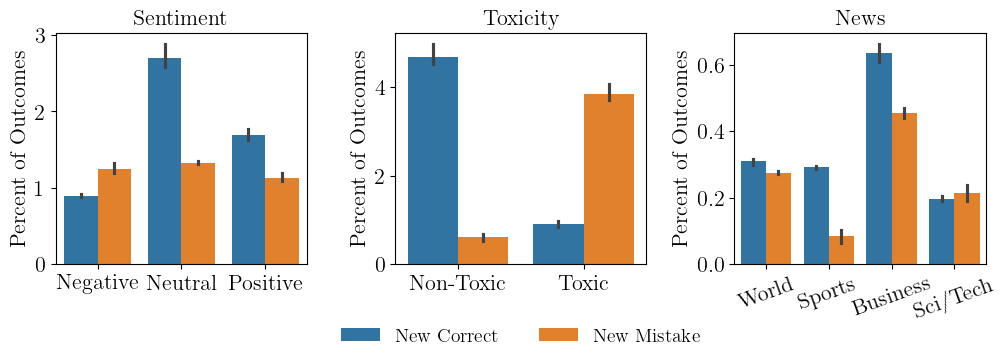

In [39]:
plt.clf()
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))

sns.barplot(
    data=multiseed_sentiment_icr_outcomes_percents_frame,
    ax=axes[0],
    x="label",
    y="proportion",
    hue="outcome",
)

sns.barplot(
    data=multiseed_toxicity_icr_outcomes_percents_frame,
    ax=axes[1],
    x="label",
    y="proportion",
    hue="outcome",
)

sns.barplot(
    data=multiseed_tweets_icr_outcomes_percents_frame,
    ax=axes[2],
    x="label",
    y="proportion",
    hue="outcome",
)

for i in range(3):
    # make y axis percents
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize between 0 and 0.1
    # axes[i].set_ylim(0, 0.09)

    # set y label to percent of overall outcomes
    axes[i].set_ylabel("Percent of Outcomes")

    # remove x label
    axes[i].set_xlabel("")

    # make the y axis percents that go to the hundreds place
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.1%}")

    if i == 2:
        # rotate the x labels
        axes[i].tick_params(axis="x", rotation=X_LABEL_ROTATION)

    # have fewer ticks on the y axis
    axes[i].locator_params(axis="y", nbins=5)

    # set titles
    title_text = {
        0: "Sentiment",
        1: "Toxicity",
        2: "News",
    }
    axes[i].set_title(title_text[i], fontsize=TITLE_FONT_SIZE)

    # have a single legend which is centered below the plot
    if i == 1:
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=False, fontsize=14)
    else:
        axes[i].get_legend().remove()

# add more horizental spacing for y labels
fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE)
fig.savefig("figures_tmlr/method_analysis_class_analysis.pdf", bbox_inches="tight")
fig.savefig("figures_tmlr/method_analysis_class_analysis.png", bbox_inches="tight")
fig.show()

# Entropy-Based Selective Augmentation 

In [40]:
def should_augment_entropy(threshold, row):
    return row["original_prediction_entropy"] >= threshold


def get_entropy_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_entropy(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = inference_logs_frame.apply(lambda row: should_augment_entropy(threshold, row), axis=1).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


def should_augment_softmax(threshold, row):
    try:
        return row["tta_all_class_probs"][-1].max() < threshold
    except:
        return False


def get_max_softmax_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_softmax(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = (inference_logs_frame["original_prediction_entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate

thresholds = np.arange(0, 1.2, 0.0001)
print(f"Number of thresholds: {len(thresholds)}")
thresholds

Number of thresholds: 12000


array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 1.1997e+00, 1.1998e+00,
       1.1999e+00])

## Get OOD Performance At Thresholds

In [41]:
id_optimal_entropy_thresholds = {}
thresholds = np.arange(0, 1.2, 0.0001)
print(f"Number of thresholds: {len(thresholds)}")

if os.path.exists("data/id_optimal_entropy_thresholds.json"):
    with open("data/id_optimal_entropy_thresholds.json", "r") as f:
        id_optimal_entropy_thresholds = json.load(f)
else:
    for split in [dataset for dataset in inference_logs if not is_entropy_split(dataset) and "Ablate" not in dataset and "ID_BERT" in dataset]:
        if "Paraphrase" not in split and "ICR" not in split:
            continue

        print(split)
        best_entropy_threshold = None
        split_frame = inference_logs[split].to_pandas()
        unique_predicted_classes = [class_label for class_label in split_frame["tta_predicted_class"].unique() if class_label != -1] 
        
        threshold_performances = []
        for threshold in tqdm(thresholds):
            accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, split_frame)
            beta = 1/500
            rate_term = 1 - llm_call_rate
            threshold_score = (1 + beta ** 2) * ((accuracy * rate_term) / ((beta ** 2) * accuracy + rate_term))
            threshold_perf = {
                "threshold": threshold,
                "accuracy": accuracy,
                "score": threshold_score,
                "llm_call_rate": f"{llm_call_rate:.2f}%",
            }
            threshold_performances.append(threshold_perf)

            # if best_entropy_threshold is None or accuracy > best_entropy_threshold["accuracy"]:
            if best_entropy_threshold is None or threshold_score > best_entropy_threshold["score"]:
                best_entropy_threshold = threshold_perf

        pd.DataFrame(threshold_performances).to_csv(f"data/threshold_performances_{split}.csv", index=False)
        id_optimal_entropy_thresholds[split] = best_entropy_threshold
        print(f"Best Entropy Threshold: {best_entropy_threshold}")

print(json.dumps(id_optimal_entropy_thresholds, indent=4))

Number of thresholds: 12000
{
    "BOSS_Sentiment_ID_BERT_Paraphrase": {
        "threshold": 0.6234000000000001,
        "accuracy": 0.9090067859346083,
        "score": 0.9090067510567909,
        "llm_call_rate": "0.10%"
    },
    "BOSS_Sentiment_ID_BERT_ICR": {
        "threshold": 0.5474,
        "accuracy": 0.9120141887723627,
        "score": 0.9120140205517979,
        "llm_call_rate": "0.13%"
    },
    "BOSS_Toxicity_ID_BERT_Paraphrase": {
        "threshold": 0.0001,
        "accuracy": 0.9075524044389642,
        "score": 0.9075512596649691,
        "llm_call_rate": "0.31%"
    },
    "BOSS_Toxicity_ID_BERT_ICR": {
        "threshold": 0.0001,
        "accuracy": 0.9169646526921497,
        "score": 0.9169634460108806,
        "llm_call_rate": "0.31%"
    },
    "AgNewsTweets_ID_BERT_Paraphrase": {
        "threshold": 0.22290000000000001,
        "accuracy": 0.9494736842105264,
        "score": 0.9494738478905508,
        "llm_call_rate": "0.01%"
    },
    "AgNewsTweets_

Use the best ID test set entropy instead of the best OOD entropy

In [42]:
def map_ood_to_id_entropy(split_name):
    method_name = split_name.split("_")[-1]
    model_name = split_name.split("_")[-2]
    distribution_name = split_name.split("_")[-3]
    task_name = split_name.replace(f"_{distribution_name}_{model_name}_{method_name}", "")
    return f"{task_name}_ID_{model_name}_{method_name}"

map_ood_to_id_entropy("BOSS_Toxicity_Toxigen_BERT_ICR")

'BOSS_Toxicity_ID_BERT_ICR'

In [43]:
file_name = "data/id_optimal_entropy_thresholds.json"
if not os.path.exists(file_name):
    with open(file_name, "w") as f:
        json.dump(id_optimal_entropy_thresholds, f, indent=4)
else:
    print("File already exists")

File already exists


The augmentation rate is the percentage of examples requiring augmentation. That is, the percent of examples which's entropy is above the threshold. These examples are unchanged across experiment runs. Thus, while the TTA performance will vary somewhat due to different augmentations, the augmentation rate will be constant.

In [44]:
perf_records = []
for seed in multiseed_inference_logs:
    for split_name in tqdm(multiseed_inference_logs[seed], desc=f"Seed = {seed}"):
        is_bert_split = "BERT" in split_name
        is_ablate_frame = "Ablate" in split_name
        is_llm_tta_split = "ICR" in split_name or "Paraphrase" in split_name
        if not is_bert_split or not is_llm_tta_split or is_ablate_frame:
            continue

        split_logs = multiseed_inference_logs[seed][split_name].to_pandas()
        id_split_name = map_ood_to_id_entropy(split_name)
        optimal_entropy_threshold = id_optimal_entropy_thresholds[id_split_name]["threshold"]
        accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, split_logs)[0]
        tta_method = parse_tta_method(split_name)
        task = parse_task_name(split_name)
        dataset = parse_distribution(split_name)
        aug_rate = split_logs.apply(lambda row: should_augment_entropy(optimal_entropy_threshold, row), axis=1).sum() / len(split_logs) * 100
        perf_records.append({
            "task": task,
            "dataset": dataset,
            "seed": seed,
            "tta": tta_method,
            "accuracy": accuracy * 100,
            "augmentation_rate": aug_rate,
        })

perf_records

Seed = 58: 100%|██████████| 268/268 [00:01<00:00, 261.20it/s]


[{'task': 'Sentiment',
  'dataset': 'SST5',
  'seed': 3,
  'tta': 'Paraphrase',
  'accuracy': 70.97378277153558,
  'augmentation_rate': 33.146067415730336},
 {'task': 'Sentiment',
  'dataset': 'SST5',
  'seed': 3,
  'tta': 'ICR',
  'accuracy': 72.65917602996255,
  'augmentation_rate': 39.60674157303371},
 {'task': 'Sentiment',
  'dataset': 'SemEval',
  'seed': 3,
  'tta': 'Paraphrase',
  'accuracy': 47.943943361458636,
  'augmentation_rate': 59.877800407331975},
 {'task': 'Sentiment',
  'dataset': 'SemEval',
  'seed': 3,
  'tta': 'ICR',
  'accuracy': 49.049558723693146,
  'augmentation_rate': 65.46406750072737},
 {'task': 'Sentiment',
  'dataset': 'Dynasent',
  'seed': 3,
  'tta': 'Paraphrase',
  'accuracy': 45.949074074074076,
  'augmentation_rate': 58.51851851851851},
 {'task': 'Sentiment',
  'dataset': 'Dynasent',
  'seed': 3,
  'tta': 'ICR',
  'accuracy': 47.40740740740741,
  'augmentation_rate': 64.51388888888889},
 {'task': 'Toxicity',
  'dataset': 'Toxigen',
  'seed': 3,
  'tta'

In [45]:
results_frame = pd.DataFrame(perf_records).groupby(["seed", "task", "tta"]).mean(["accuracy", "augmentation_rate"]).reset_index()
display(results_frame)
results_frame.drop(columns=["seed"]).groupby(["task", "tta"]).agg(["mean", "std"]).round(2).T

,seed,task,tta,accuracy,augmentation_rate
0,3,News,ICR,89.239674,3.762168
1,3,News,Paraphrase,88.818732,1.617995
2,3,Sentiment,ICR,56.372047,56.528233
3,3,Sentiment,Paraphrase,54.955600,50.514129
4,3,Toxicity,ICR,58.411757,66.499113
5,3,Toxicity,Paraphrase,61.424983,66.499113
6,17,News,ICR,89.239674,3.762168
7,17,News,Paraphrase,88.884504,1.617995
8,17,Sentiment,ICR,56.169792,56.528233
9,17,Sentiment,Paraphrase,54.808111,50.514129


task                     News            Sentiment            Toxicity  \
tta                       ICR Paraphrase       ICR Paraphrase      ICR   
accuracy          mean  89.21      88.80     56.38      54.77    58.33   
                  std    0.04       0.06      0.16       0.15     0.15   
augmentation_rate mean   3.76       1.62     56.53      50.51    66.50   
                  std    0.00       0.00      0.00       0.00     0.00   

task                               
tta                    Paraphrase  
accuracy          mean      61.24  
                  std        0.35  
augmentation_rate mean      66.50  
                  std        0.00

In [46]:
aggregated_results_frame = results_frame.groupby(["seed", "task", "tta"]).mean(["accuracy", "augmentation_rate"]).reset_index()
aggregated_results_frame

,seed,task,tta,accuracy,augmentation_rate
0,3,News,ICR,89.239674,3.762168
1,3,News,Paraphrase,88.818732,1.617995
2,3,Sentiment,ICR,56.372047,56.528233
3,3,Sentiment,Paraphrase,54.955600,50.514129
4,3,Toxicity,ICR,58.411757,66.499113
5,3,Toxicity,Paraphrase,61.424983,66.499113
6,17,News,ICR,89.239674,3.762168
7,17,News,Paraphrase,88.884504,1.617995
8,17,Sentiment,ICR,56.169792,56.528233
9,17,Sentiment,Paraphrase,54.808111,50.514129


In [47]:
across_seed_results_frame = aggregated_results_frame.drop(columns="seed").groupby(["task", "tta"]).agg(["mean", "std"]).round(2).T
across_seed_results_frame

task                     News            Sentiment            Toxicity  \
tta                       ICR Paraphrase       ICR Paraphrase      ICR   
accuracy          mean  89.21      88.80     56.38      54.77    58.33   
                  std    0.04       0.06      0.16       0.15     0.15   
augmentation_rate mean   3.76       1.62     56.53      50.51    66.50   
                  std    0.00       0.00      0.00       0.00     0.00   

task                               
tta                    Paraphrase  
accuracy          mean      61.24  
                  std        0.35  
augmentation_rate mean      66.50  
                  std        0.00

## Create ESA Table

In [48]:
esa_table_lines = [
    f'None & {aggregated_main_results["BOSS_Sentiment"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]}\\% & - & {aggregated_main_results["BOSS_Toxicity"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]}\\% & - & {aggregated_main_results["AgNewsTweets"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]}\\% & - \\\\',
    "\cdashlinelr{1-7}",
    f'Paraphrase: Default & {aggregated_main_results["BOSS_Sentiment"]["BERT"]["Paraphrase"]["ood_mean_accuracy"]["mean"]}\\% {{\\tiny $\pm {aggregated_main_results["BOSS_Sentiment"]["BERT"]["Paraphrase"]["ood_mean_accuracy"]["std"]:.1f}$}} & 100.00\\% & {aggregated_main_results["BOSS_Toxicity"]["BERT"]["Paraphrase"]["ood_mean_accuracy"]["mean"]}\\% {{\\tiny $\pm {aggregated_main_results["BOSS_Toxicity"]["BERT"]["Paraphrase"]["ood_mean_accuracy"]["std"]:.1f}$}} & 100.00\\% & {aggregated_main_results["AgNewsTweets"]["BERT"]["Paraphrase"]["ood_mean_accuracy"]["mean"]}\\% {{\\tiny $\pm {aggregated_main_results["AgNewsTweets"]["BERT"]["Paraphrase"]["ood_mean_accuracy"]["std"]:.1f}$}} & 100.00\\% \\\\',
    f'Paraphrase: ESA & {across_seed_results_frame["Sentiment"]["Paraphrase"]["accuracy"]["mean"]}\\% {{\\tiny $\pm {across_seed_results_frame["Sentiment"]["Paraphrase"]["accuracy"]["std"]:.1f}$}} & {across_seed_results_frame["Sentiment"]["Paraphrase"]["augmentation_rate"]["mean"]:.2f}\\% & {across_seed_results_frame["Toxicity"]["Paraphrase"]["accuracy"]["mean"]}\\% {{\\tiny $\pm {across_seed_results_frame["Toxicity"]["Paraphrase"]["accuracy"]["std"]:.1f}$}} & {across_seed_results_frame["Toxicity"]["Paraphrase"]["augmentation_rate"]["mean"]:.2f}\\% & {across_seed_results_frame["News"]["Paraphrase"]["accuracy"]["mean"]}\\% {{\\tiny $\pm {across_seed_results_frame["News"]["Paraphrase"]["accuracy"]["std"]:.1f}$}} & {across_seed_results_frame["News"]["Paraphrase"]["augmentation_rate"]["mean"]:.2f}\\% \\\\',
    "\cdashlinelr{1-7}",
    f'ICR: Default & {aggregated_main_results["BOSS_Sentiment"]["BERT"]["ICR"]["ood_mean_accuracy"]["mean"]}\\% {{\\tiny $\pm {aggregated_main_results["BOSS_Sentiment"]["BERT"]["ICR"]["ood_mean_accuracy"]["std"]:.1f}$}} & 100.00\\% & {aggregated_main_results["BOSS_Toxicity"]["BERT"]["ICR"]["ood_mean_accuracy"]["mean"]}\\% {{\\tiny $\pm {aggregated_main_results["BOSS_Toxicity"]["BERT"]["ICR"]["ood_mean_accuracy"]["std"]:.1f}$}} & 100.00\\% & {aggregated_main_results["AgNewsTweets"]["BERT"]["ICR"]["ood_mean_accuracy"]["mean"]}\\% {{\\tiny $\pm {aggregated_main_results["AgNewsTweets"]["BERT"]["ICR"]["ood_mean_accuracy"]["std"]:.1f}$}} & 100.00\\% \\\\',
    f'ICR: ESA & {across_seed_results_frame["Sentiment"]["ICR"]["accuracy"]["mean"]}\\% {{\\tiny $\pm {across_seed_results_frame["Sentiment"]["ICR"]["accuracy"]["std"]:.1f}$}} & {across_seed_results_frame["Sentiment"]["ICR"]["augmentation_rate"]["mean"]:.2f}\\% & {across_seed_results_frame["Toxicity"]["ICR"]["accuracy"]["mean"]}\\% {{\\tiny $\pm {across_seed_results_frame["Toxicity"]["ICR"]["accuracy"]["std"]:.1f}$}} & {across_seed_results_frame["Toxicity"]["ICR"]["augmentation_rate"]["mean"]:.2f}\\% & {across_seed_results_frame["News"]["ICR"]["accuracy"]["mean"]}\\% {{\\tiny $\pm {across_seed_results_frame["News"]["ICR"]["accuracy"]["std"]:.1f}$}} & {across_seed_results_frame["News"]["ICR"]["augmentation_rate"]["mean"]:.2f}\\% \\\\',
]

print("\n".join(esa_table_lines))


None & 52.05\% & - & 53.88\% & - & 88.57\% & - \\
\cdashlinelr{1-7}
Paraphrase: Default & 55.24\% {\tiny $\pm 0.2$} & 100.00\% & 64.67\% {\tiny $\pm 0.3$} & 100.00\% & 88.97\% {\tiny $\pm 0.0$} & 100.00\% \\
Paraphrase: ESA & 54.77\% {\tiny $\pm 0.1$} & 50.51\% & 61.24\% {\tiny $\pm 0.3$} & 66.50\% & 88.8\% {\tiny $\pm 0.1$} & 1.62\% \\
\cdashlinelr{1-7}
ICR: Default & 57.17\% {\tiny $\pm 0.2$} & 100.00\% & 61.06\% {\tiny $\pm 0.2$} & 100.00\% & 89.72\% {\tiny $\pm 0.1$} & 100.00\% \\
ICR: ESA & 56.38\% {\tiny $\pm 0.2$} & 56.53\% & 58.33\% {\tiny $\pm 0.1$} & 66.50\% & 89.21\% {\tiny $\pm 0.0$} & 3.76\% \\


In [49]:
results_frame = pd.DataFrame(perf_records)
display(results_frame.drop(columns="dataset").groupby(["seed", "task", "tta"]).agg(["mean", "std"]).T)

aggregated_esa_results = results_frame.drop(columns=["dataset", "seed"]).groupby(["task", "tta"]).agg(["mean", "std"]).T
display(aggregated_esa_results)



seed                           3                                               \
task                         News             Sentiment              Toxicity   
tta                           ICR Paraphrase        ICR Paraphrase        ICR   
accuracy          mean  89.239674  88.818732  56.372047  54.955600  58.411757   
                  std         NaN        NaN  14.128945  13.907966  13.669820   
augmentation_rate mean   3.762168   1.617995  56.528233  50.514129  66.499113   
                  std         NaN        NaN  14.662140  15.056529   8.995636   

seed                                      17                                   \
task                                    News             Sentiment              
tta                    Paraphrase        ICR Paraphrase        ICR Paraphrase   
accuracy          mean  61.424983  89.239674  88.884504  56.169792  54.808111   
                  std    7.512666        NaN        NaN  13.491763  14.056676   
augmentation_rate mean  66.499113   3.762168   1.617995  56.528233  50.514129   
                  std    8.995636        NaN        NaN  14.662140  15.056529   

seed                                                 46                        \
task                     Toxicity                  News             Sentiment   
tta                           ICR Paraphrase        ICR Paraphrase        ICR   
accuracy          mean  58.309010  60.983701  89.213365  88.739805  56.442666   
                  std   13.576285   8.278629        NaN        NaN  13.737280   
augmentation_rate mean  66.499113  66.499113   3.762168   1.617995  56.528233   
                  std    8.995636   8.995636        NaN        NaN  14.662140   

seed                                                            58             \
task                                Toxicity                  News              
tta                    Paraphrase        ICR Paraphrase        ICR Paraphrase   
accuracy          mean  54.708588  58.126091  61.645326  89.160747  88.766114   
                  std   13.645266  13.314560   6.963902        NaN        NaN   
augmentation_rate mean  50.514129  66.499113  66.499113   3.762168   1.617995   
                  std   15.056529   8.995636   8.995636        NaN        NaN   

seed                                                                
task                    Sentiment              Toxicity             
tta                           ICR Paraphrase        ICR Paraphrase  
accuracy          mean  56.550481  54.606125  58.473577  60.921717  
                  std   13.886890  13.835919  13.090917   8.331811  
augmentation_rate mean  56.528233  50.514129  66.499113  66.499113  
                  std   14.662140  15.056529   8.995636   8.995636

task                         News             Sentiment              Toxicity  \
tta                           ICR Paraphrase        ICR Paraphrase        ICR   
accuracy          mean  89.213365  88.802289  56.383747  54.769606  58.330109   
                  std    0.037206   0.063881  11.780794  11.822532  11.441019   
augmentation_rate mean   3.762168   1.617995  56.528233  50.514129  66.499113   
                  std    0.000000   0.000000  12.503915  12.840251   7.671505   

task                               
tta                    Paraphrase  
accuracy          mean  61.243932  
                  std    6.652942  
augmentation_rate mean  66.499113  
                  std    7.671505

# Abstract & Introduction

## Abstract

In [67]:
# LLM-TTA outperforms conventional augmentation functions across sentiment, toxicity, and news classification tasks for BERT and T5 models, with BERT's OOD 
# robustness improving by an average of X.XX percentage points without regressing average ID performance. 

icr_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["BERT"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
icr_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["BERT"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
icr_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["BERT"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([icr_sentiment_ood_improvement, icr_toxicity_ood_improvement, icr_news_ood_improvement])

print("ICR: " + str(improvements))
print(improvements.mean().round(2))

translation_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["BERT"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
translation_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["BERT"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
translation_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["BERT"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([translation_sentiment_ood_improvement, translation_toxicity_ood_improvement, translation_news_ood_improvement])

print("Translation:" + str(improvements))
print(improvements.mean().round(2))

insertion_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["BERT"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
insertion_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["BERT"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
insertion_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["BERT"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([insertion_sentiment_ood_improvement, insertion_toxicity_ood_improvement, insertion_news_ood_improvement])

print("Insertion:" + str(improvements))
print(improvements.mean().round(2))

substitution_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["BERT"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
substitution_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["BERT"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
substitution_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["BERT"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([substitution_sentiment_ood_improvement, substitution_toxicity_ood_improvement, substitution_news_ood_improvement])

print("Substitution:" + str(improvements))
print(improvements.mean().round(2))


ICR: [5.12 7.18 1.15]
4.48
Translation:[ 0.36  8.23 -0.04]
2.85
Insertion:[-0.39 -0.77  0.29]
-0.29
Substitution:[-0.61 -1.18  0.2 ]
-0.53


In [75]:
# Same but with T5
# LLM-TTA outperforms conventional augmentation functions across sentiment, toxicity, and news classification tasks for T5 and T5 models, with T5's OOD 
# robustness improving by an average of X.XX percentage points without regressing average ID performance. 

icr_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["T5"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
icr_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["T5"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
icr_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["T5"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([icr_sentiment_ood_improvement, icr_toxicity_ood_improvement, icr_news_ood_improvement])

print("ICR: " + str(improvements))
print(improvements.mean().round(2))

translation_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["T5"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
translation_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["T5"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
translation_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["T5"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([translation_sentiment_ood_improvement, translation_toxicity_ood_improvement, translation_news_ood_improvement])

print("Translation:" + str(improvements))
print(improvements.mean().round(2))

insertion_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["T5"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
insertion_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["T5"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
insertion_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["T5"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([insertion_sentiment_ood_improvement, insertion_toxicity_ood_improvement, insertion_news_ood_improvement])

print("Insertion:" + str(improvements))
print(improvements.mean().round(2))

substitution_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["T5"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
substitution_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["T5"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
substitution_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["T5"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["T5"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([substitution_sentiment_ood_improvement, substitution_toxicity_ood_improvement, substitution_news_ood_improvement])

print("Substitution:" + str(improvements))
print(improvements.mean().round(2))


ICR: [1.66 5.   1.31]
2.66
Translation:[-1.49  4.57  0.14]
1.07
Insertion:[-1.98 -1.24  0.7 ]
-0.84
Substitution:[-3.94 -1.84  0.09]
-1.9


In [70]:
# Same but with Falcon
# LLM-TTA outperforms conventional augmentation functions across sentiment, toxicity, and news classification tasks for Falcon and Falcon models, with Falcon's OOD 
# robustness improving by an average of X.XX percentage points without regressing average ID performance. 

icr_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["Falcon"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
icr_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["Falcon"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
icr_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["Falcon"]["ICR"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([icr_sentiment_ood_improvement, icr_toxicity_ood_improvement, icr_news_ood_improvement])

print("ICR: " + str(improvements))
print(improvements.mean().round(2))

translation_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["Falcon"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
translation_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["Falcon"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
translation_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["Falcon"]["Translate"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([translation_sentiment_ood_improvement, translation_toxicity_ood_improvement, translation_news_ood_improvement])

print("Translation:" + str(improvements))
print(improvements.mean().round(2))

insertion_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["Falcon"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
insertion_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["Falcon"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
insertion_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["Falcon"]["Insert"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([insertion_sentiment_ood_improvement, insertion_toxicity_ood_improvement, insertion_news_ood_improvement])

print("Insertion:" + str(improvements))
print(improvements.mean().round(2))

substitution_sentiment_ood_improvement = aggregated_main_results["BOSS_Sentiment"]["Falcon"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
substitution_toxicity_ood_improvement = aggregated_main_results["BOSS_Toxicity"]["Falcon"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["BOSS_Toxicity"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
substitution_news_ood_improvement = aggregated_main_results["AgNewsTweets"]["Falcon"]["Substitute"]["ood_mean_accuracy"]["mean"] - aggregated_main_results["AgNewsTweets"]["Falcon"]["None"]["ood_mean_accuracy"]["mean"]
improvements = np.array([substitution_sentiment_ood_improvement, substitution_toxicity_ood_improvement, substitution_news_ood_improvement])

print("Substitution:" + str(improvements))
print(improvements.mean().round(2))


ICR: [-2.98 -1.    1.96]
-0.67
Translation:[-2.75 -0.03  1.02]
-0.59
Insertion:[-0.95 -1.78 -0.88]
-1.2
Substitution:[-3.21 -0.24 -1.08]
-1.51


In [74]:
# BERT's robustness on sentiment is improved by 4.16 points when only augmenting 56.51\% of inputs compared to 4.86 points when augmenting every input
icr_esa_sentiment_ood_improvement = across_seed_results_frame["Sentiment"]["ICR"]["accuracy"]["mean"] - aggregated_main_results["BOSS_Sentiment"]["BERT"]["None"]["ood_mean_accuracy"]["mean"]
icr_esa_sentiment_ood_improvement_augmentation_rate = across_seed_results_frame["Sentiment"]["ICR"]["augmentation_rate"]["mean"]
print(icr_esa_sentiment_ood_improvement.round(2))
print(icr_esa_sentiment_ood_improvement_augmentation_rate.round(2))

4.33
56.53


In [59]:
# We explore selectively augmenting inputs based on prediction entropy to reduce the rate of expensive LLM augmentations, allowing us to maintain performance gains while 
# reducing the average number of generated augmentations by X.XX\%

sentiment_augmentation_rate = across_seed_results_frame["Sentiment"]["ICR"]["augmentation_rate"]["mean"]
toxicity_augmentation_rate = across_seed_results_frame["Toxicity"]["ICR"]["augmentation_rate"]["mean"]
news_augmentation_rate = across_seed_results_frame["News"]["ICR"]["augmentation_rate"]["mean"]
augmentation_rates = np.array([sentiment_augmentation_rate, toxicity_augmentation_rate, news_augmentation_rate])
print(augmentation_rates)
print(100 - augmentation_rates.mean().round(2))

[56.53 66.5   3.76]
57.74
